Model training and prediction

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Load the data
historical_df = pd.read_csv('final_historical.csv')
future_df = pd.read_csv('future_all_df_wd_85.csv')

# Filter historical data up to 2013 as specified
historical_df['date'] = pd.to_datetime(historical_df['date'])
historical_df = historical_df[historical_df['date'] <= '2013-12-31']

# Format future data dates for consistency
future_df['date'] = pd.to_datetime(future_df['date'], format='%Y-%m')

print(f"Historical data shape: {historical_df.shape}")
print(f"Future data shape: {future_df.shape}")

# 2. Feature Engineering Function
def create_lag_features(df, target_cols, lag_periods=[1, 2, 3], roll_window=7):
    """
    Create lag and rolling features for the target columns.
    
    Parameters:
    df: DataFrame with time-indexed data
    target_cols: List of columns to create lag/rolling features for (D0-D4)
    lag_periods: List of lag periods in months
    roll_window: Window size for rolling calculations in months
    
    Returns:
    DataFrame with added lag and rolling features
    """
    df = df.copy()
    
    # Ensure the dataframe is sorted by date
    df = df.sort_values('date')
    
    # Create lag features for each target column
    for col in target_cols:
        for lag in lag_periods:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    # Create rolling mean and std features
    for col in target_cols:
        df[f'{col}_roll_mean_{roll_window}'] = df[col].rolling(window=roll_window).mean()
        df[f'{col}_roll_std_{roll_window}'] = df[col].rolling(window=roll_window).std()
    
    return df

# 3. Create features for historical data
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
lag_periods = [1, 2, 3]
roll_window = 7

# Apply feature engineering to historical data
historical_df_features = create_lag_features(historical_df, target_cols, lag_periods, roll_window)

# Drop rows with NaN values (first 7 months due to rolling window)
historical_df_features = historical_df_features.dropna()
print(f"Historical data after feature engineering: {historical_df_features.shape}")

# 4. Prepare training data
# Meteorological and hydrological features
feature_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']

# Add lag and rolling features to the feature columns
for col in target_cols:
    for lag in lag_periods:
        feature_cols.append(f'{col}_lag_{lag}')
    feature_cols.append(f'{col}_roll_mean_{roll_window}')
    feature_cols.append(f'{col}_roll_std_{roll_window}')

# Separate features and targets
X_train = historical_df_features[feature_cols]
Y_train = historical_df_features[target_cols]

# 5. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)

# 6. Train a stacked model for each drought severity level
models = {}
for col in target_cols:
    # Base estimators
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    
    # Stacked model
    estimators = [('rf', rf), ('xgb', xgb)]
    stacked_model = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(random_state=42))
    
    # Train the model
    stacked_model.fit(X_train_scaled, Y_train[col])
    
    # Save the model
    models[col] = stacked_model
    
    # Print model performance
    y_pred = stacked_model.predict(X_train_scaled)
    r2 = r2_score(Y_train[col], y_pred)
    print(f"R² score for {col}: {r2:.4f}")

# 7. Autoregressive prediction function
def autoregressive_predict(models, scaler, future_df, historical_df, target_cols, lag_periods, roll_window, feature_cols):
    """
    Make autoregressive predictions on future data.
    
    Parameters:
    models: Dictionary of trained models for each target
    scaler: Fitted StandardScaler
    future_df: DataFrame with future meteorological/hydrological data
    historical_df: DataFrame with historical data including D0-D4
    target_cols: List of target columns (D0-D4)
    lag_periods: List of lag periods
    roll_window: Rolling window size
    feature_cols: List of feature columns
    
    Returns:
    DataFrame with predictions
    """
    # Prepare a dataframe for predictions that includes historical + future data
    # This allows us to create proper lag/rolling features at the boundary
    combined_df = pd.concat([historical_df, future_df], ignore_index=True)
    combined_df = combined_df.sort_values('date')
    
    # Initialize target columns in future data with NaN
    for col in target_cols:
        if col not in combined_df.columns:
            combined_df[col] = np.nan
    
    # Identify the boundary between historical and future data
    future_start_idx = combined_df[combined_df['date'] >= future_df['date'].min()].index[0]
    
    # Iteratively predict one month at a time
    for i in range(future_start_idx, len(combined_df)):
        # Create lag and rolling features up to the current point
        temp_df = combined_df.iloc[:i+1].copy()
        temp_df = create_lag_features(temp_df, target_cols, lag_periods, roll_window)
        
        # If we have all required features (no NaN), make a prediction
        current_row = temp_df.iloc[-1:].copy()
        
        # Check if we have all required features
        if not current_row[feature_cols].isna().any().any():
            # Scale features
            current_features = current_row[feature_cols]
            current_features_scaled = scaler.transform(current_features)
            
            # Make predictions for each target
            for col in target_cols:
                prediction = models[col].predict(current_features_scaled)[0]
                combined_df.loc[i, col] = prediction
    
    # Return only the future predictions
    future_predictions = combined_df[combined_df['date'] >= future_df['date'].min()].copy()
    
    return future_predictions

# 8. Make autoregressive predictions
future_predictions = autoregressive_predict(
    models, scaler, future_df, historical_df, 
    target_cols, lag_periods, roll_window, feature_cols
)

# 9. Visualize predictions
plt.figure(figsize=(15, 10))

for i, col in enumerate(target_cols):
    plt.subplot(3, 2, i+1)
    
    # Plot historical data
    plt.plot(historical_df['date'], historical_df[col], label='Historical')
    
    # Plot predictions
    plt.plot(future_predictions['date'], future_predictions[col], label='Predicted')
    
    plt.title(f'Drought Severity: {col}')
    plt.xlabel('Date')
    plt.ylabel('Percent Area')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('drought_predictions.png')
plt.close()

# 10. Save predictions to CSV
future_predictions.to_csv('future_drought_predictions.csv', index=False)

print("Autoregressive prediction completed and saved to 'future_drought_predictions.csv'")

# 11. Additional analysis - check how well the model predicts historical data
# For this, we can simulate an autoregressive approach on the last year of historical data
test_cutoff = pd.to_datetime('2012-12-31')
train_df = historical_df[historical_df['date'] <= test_cutoff].copy()
test_df = historical_df[historical_df['date'] > test_cutoff].copy()

# Train models on data up to 2012
train_df_features = create_lag_features(train_df, target_cols, lag_periods, roll_window)
train_df_features = train_df_features.dropna()

X_val_train = train_df_features[feature_cols]
Y_val_train = train_df_features[target_cols]

val_scaler = StandardScaler()
X_val_train_scaled = val_scaler.fit_transform(X_val_train)

val_models = {}
for col in target_cols:
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    
    estimators = [('rf', rf), ('xgb', xgb)]
    stacked_model = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(random_state=42))
    
    stacked_model.fit(X_val_train_scaled, Y_val_train[col])
    val_models[col] = stacked_model

# Make autoregressive predictions on 2013 data
validation_predictions = autoregressive_predict(
    val_models, val_scaler, test_df, train_df, 
    target_cols, lag_periods, roll_window, feature_cols
)

# Calculate validation metrics
validation_metrics = {}
for col in target_cols:
    actual = test_df[col]
    predicted = validation_predictions[col]
    r2 = r2_score(actual, predicted)
    validation_metrics[col] = {'r2': r2}
    print(f"Validation R² for {col}: {r2:.4f}")

# Visualize validation predictions vs. actual
plt.figure(figsize=(15, 10))

for i, col in enumerate(target_cols):
    plt.subplot(3, 2, i+1)
    
    # Plot actual data
    plt.plot(test_df['date'], test_df[col], label='Actual')
    
    # Plot validation predictions
    plt.plot(validation_predictions['date'], validation_predictions[col], label='Predicted')
    
    plt.title(f'Validation: {col} (R² = {validation_metrics[col]["r2"]:.4f})')
    plt.xlabel('Date')
    plt.ylabel('Percent Area')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('validation_predictions.png')
plt.close()

print("Validation completed and results saved to 'validation_predictions.png'")

Historical data shape: (768, 15)
Future data shape: (900, 10)
Historical data after feature engineering: (762, 40)
R² score for D0: 0.9267
R² score for D1: 0.8869
R² score for D2: 0.7153
R² score for D3: 0.5204
R² score for D4: 0.5790
Autoregressive prediction completed and saved to 'future_drought_predictions.csv'
Validation R² for D0: -0.2543
Validation R² for D1: -3.1870
Validation R² for D2: -16.8746
Validation R² for D3: -4.3331
Validation R² for D4: 0.0000
Validation completed and results saved to 'validation_predictions.png'



========================== LOADING AND PREPARING DATA ==========================
Historical data: 768 rows from 1950-01-01 00:00:00 to 2013-12-01 00:00:00
Future data: 900 rows from 2025-01-01 00:00:00 to 2099-12-01 00:00:00

Missing values in historical data:
Unnamed: 0    0
date          0
airtemp       0
baseflow      0
ev            0
rainfall      0
runoff        0
sm            0
snowfall      0
snowwater     0
D0            0
D1            0
D2            0
D3            0
D4            0
dtype: int64

Missing values in future data:
Unnamed: 0    0
date          0
airtemp       0
baseflow      0
ev            0
rainfall      0
runoff        0
sm            0
snowfall      0
snowwater     0
dtype: int64

============================= FEATURE ENGINEERING ==============================

Target variable statistics:
D0: min=0.00, max=100.10, mean=42.54, median=31.20
D1: min=0.00, max=100.00, mean=30.76, median=9.30
D2: min=0.00, max=100.00, mean=15.37, median=0.00
D3: min=0.00, max=

Traceback (most recent call last):
  File "/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_73250/3188461694.py", line 812, in <module>
    json.dump(report, f, indent=2)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/__init__.py", line 179, in dump
    for chunk in iterable:
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/encoder.py", line 432, in _iterencode
    yield from _iterencode_dict(o, _current_indent_level)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

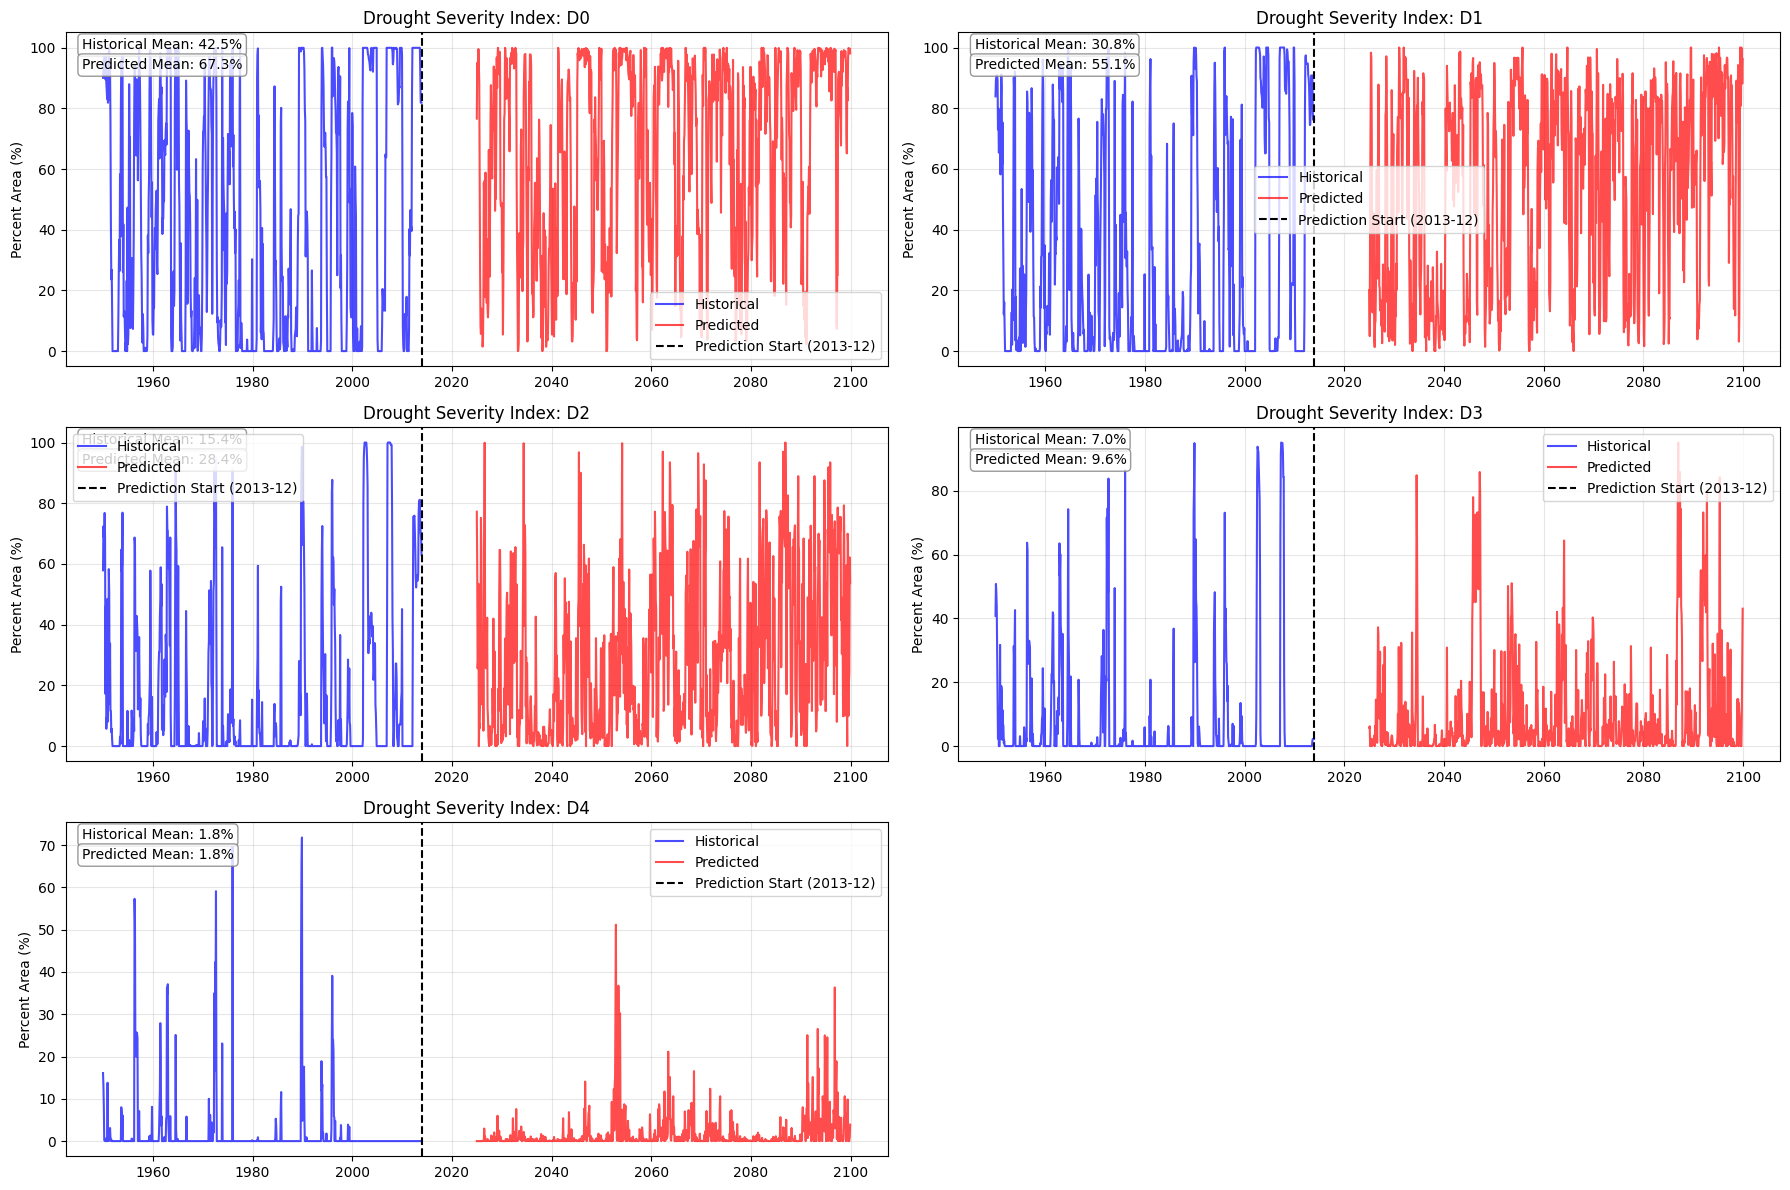

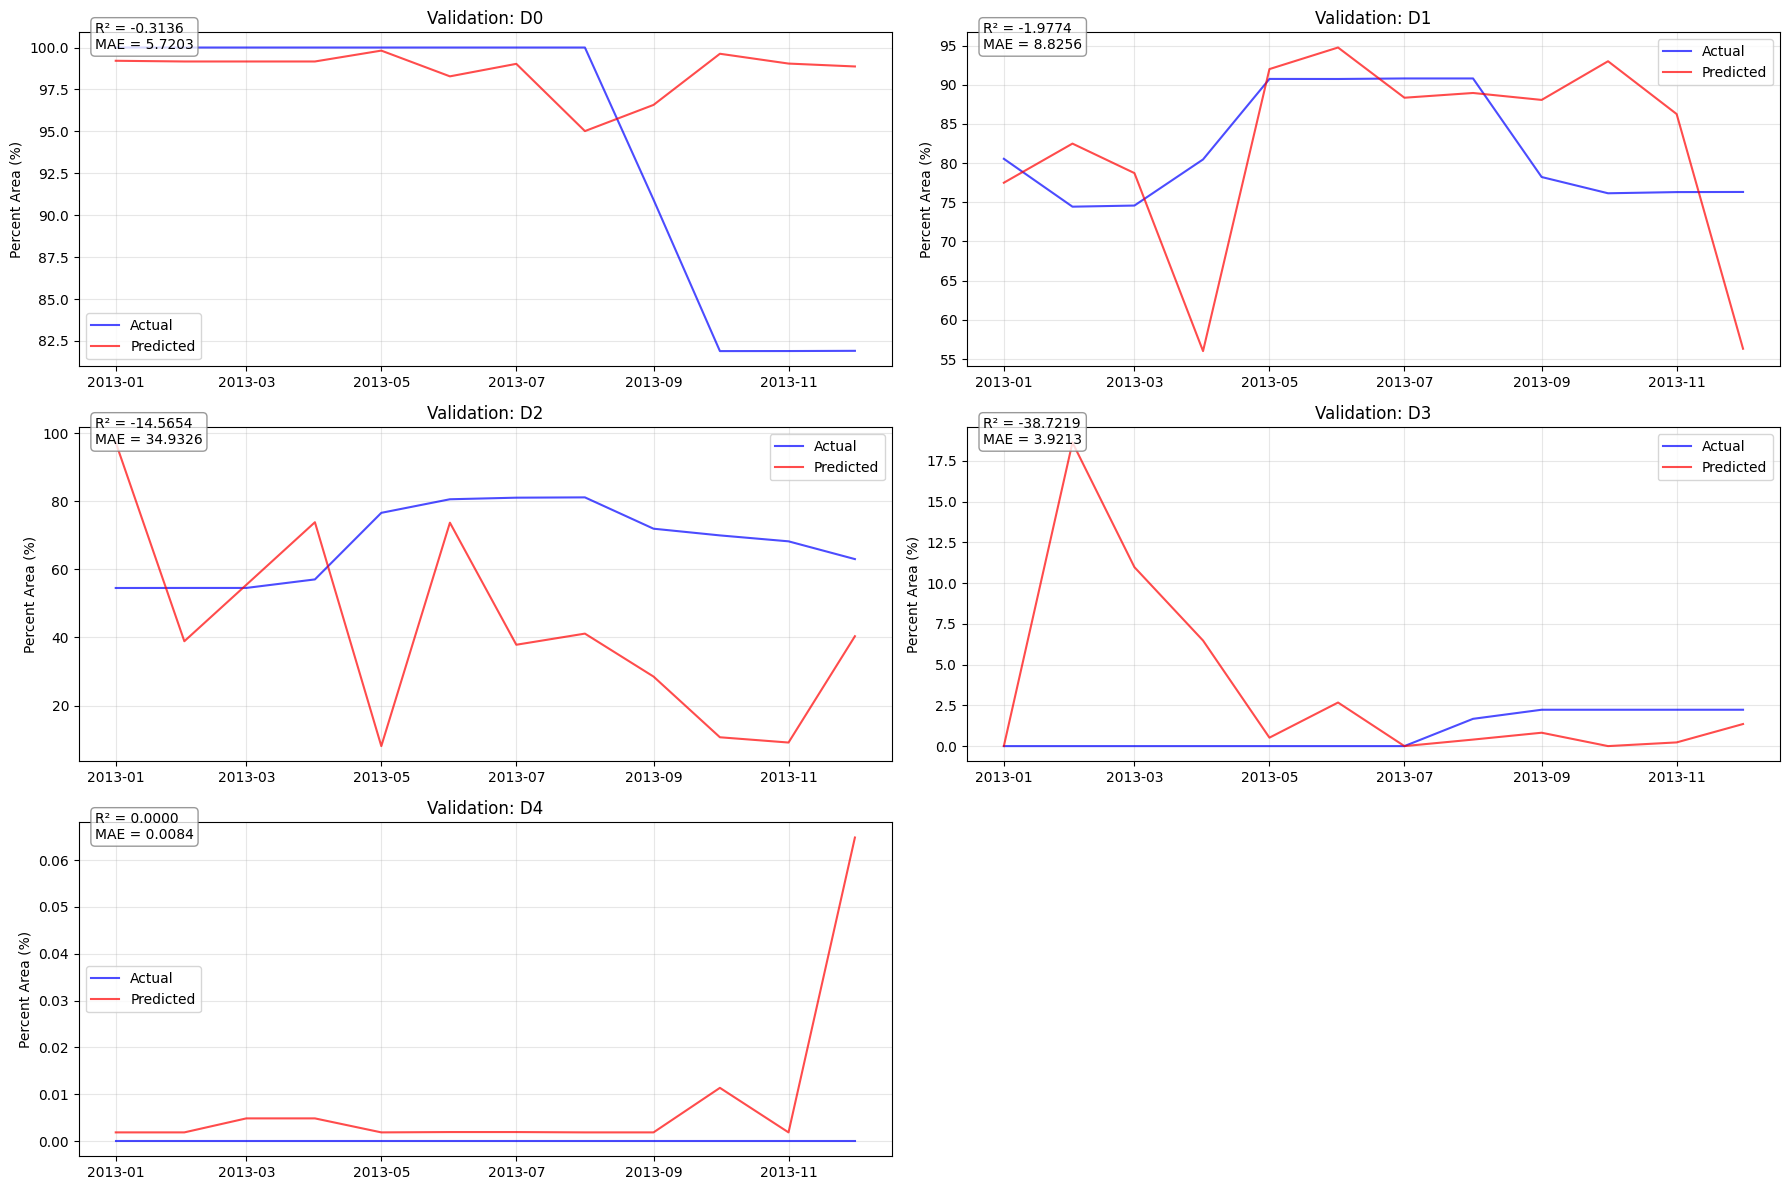

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Custom helper functions
def print_section(title):
    """Print a section header to make output more readable"""
    print("\n" + "="*80)
    print(f" {title} ".center(80, "="))
    print("="*80)

def format_date(date_str):
    """Standardize date formats from both datasets"""
    if len(date_str) <= 7:  # Format like '2025-01'
        return f"{date_str}-01"  # Add day to match historical format
    return date_str  # Already in full format

# 1. Load and prepare the data
print_section("LOADING AND PREPARING DATA")

# Load data files
historical_df = pd.read_csv('final_historical.csv')
future_df = pd.read_csv('future_all_df_wd_85.csv')

# Convert and standardize dates
historical_df['date'] = pd.to_datetime(historical_df['date'])
# Use the format_date function to ensure consistent formats
future_df['date'] = pd.to_datetime(future_df['date'].apply(format_date))

# Filter historical data up to 2013 as specified
historical_df = historical_df[historical_df['date'] <= '2013-12-31']

print(f"Historical data: {historical_df.shape[0]} rows from {historical_df['date'].min()} to {historical_df['date'].max()}")
print(f"Future data: {future_df.shape[0]} rows from {future_df['date'].min()} to {future_df['date'].max()}")

# Check for missing values
print("\nMissing values in historical data:")
print(historical_df.isna().sum())
print("\nMissing values in future data:")
print(future_df.isna().sum())

# 2. Feature Engineering Function
def create_lag_features(df, target_cols, lag_periods=[1, 2, 3], roll_window=7):
    """
    Create lag and rolling features for the target columns.
    
    Parameters:
    df: DataFrame with time-indexed data
    target_cols: List of columns to create lag/rolling features for (D0-D4)
    lag_periods: List of lag periods in months
    roll_window: Window size for rolling calculations in months
    
    Returns:
    DataFrame with added lag and rolling features
    """
    df = df.copy()
    
    # Ensure the dataframe is sorted by date
    df = df.sort_values('date')
    
    # Create lag features for each target column
    for col in target_cols:
        if col in df.columns:
            for lag in lag_periods:
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)
        else:
            print(f"Warning: Target column {col} not found in dataframe")
    
    # Create rolling mean and std features
    for col in target_cols:
        if col in df.columns:
            df[f'{col}_roll_mean_{roll_window}'] = df[col].rolling(window=roll_window, min_periods=1).mean()
            df[f'{col}_roll_std_{roll_window}'] = df[col].rolling(window=roll_window, min_periods=1).std()
            # Handle division by zero or single-value windows
            df[f'{col}_roll_std_{roll_window}'] = df[f'{col}_roll_std_{roll_window}'].fillna(0)
        else:
            print(f"Warning: Target column {col} not found in dataframe")
    
    return df

# Set up parameters
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
lag_periods = [1, 2, 3]
roll_window = 7

# 3. Create features for historical data
print_section("FEATURE ENGINEERING")

# Apply feature engineering to historical data
historical_df_features = create_lag_features(historical_df, target_cols, lag_periods, roll_window)

# Print descriptive statistics of target columns
print("\nTarget variable statistics:")
for col in target_cols:
    stats = historical_df[col].describe()
    print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}, median={stats['50%']:.2f}")

# Fill NaN values in the lag and rolled features
print("\nFilling missing values in lag and rolled features...")
for col in target_cols:
    # Get statistics for the column to use for filling
    col_mean = historical_df[col].mean()
    col_std = historical_df[col].std()
    
    # Fill lag features
    for lag in lag_periods:
        lag_col = f'{col}_lag_{lag}'
        historical_df_features[lag_col] = historical_df_features[lag_col].fillna(col_mean)
    
    # Fill rolling features
    roll_mean_col = f'{col}_roll_mean_{roll_window}'
    roll_std_col = f'{col}_roll_std_{roll_window}'
    
    historical_df_features[roll_mean_col] = historical_df_features[roll_mean_col].fillna(col_mean)
    historical_df_features[roll_std_col] = historical_df_features[roll_std_col].fillna(col_std)

# Check if any NaN values remain
nan_count = historical_df_features.isna().sum().sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values remain in the feature-engineered historical data")
    print(historical_df_features.isna().sum())
    # Drop rows with remaining NaN values as a last resort
    historical_df_features = historical_df_features.dropna()
    print(f"Dropped rows with NaN values. Remaining rows: {len(historical_df_features)}")
else:
    print("No NaN values in the feature-engineered historical data")

# 4. Prepare training data
# Define feature columns
base_feature_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']
derived_feature_cols = []

# Add lag and rolling features to the feature columns
for col in target_cols:
    for lag in lag_periods:
        derived_feature_cols.append(f'{col}_lag_{lag}')
    derived_feature_cols.append(f'{col}_roll_mean_{roll_window}')
    derived_feature_cols.append(f'{col}_roll_std_{roll_window}')

# Combine base and derived features
feature_cols = base_feature_cols + derived_feature_cols

# Separate features and targets
X_train = historical_df_features[feature_cols]
Y_train = historical_df_features[target_cols]

# 5. Scale the features
print_section("MODEL TRAINING")
print("Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)

# Print feature importance analysis
print("\nFeature correlation with target variables:")
for col in target_cols:
    correlations = X_train.corrwith(Y_train[col]).abs().sort_values(ascending=False)
    print(f"\nTop 5 features correlated with {col}:")
    print(correlations.head(5))

# 6. Train a stacked model for each drought severity level
print("\nTraining stacked models...")
models = {}

for col in target_cols:
    print(f"\nTraining model for {col}...")
    
    # Base estimators
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    
    # Stacked model
    estimators = [('rf', rf), ('xgb', xgb)]
    stacked_model = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(random_state=42))
    
    # Train the model
    stacked_model.fit(X_train_scaled, Y_train[col])
    
    # Save the model
    models[col] = stacked_model
    
    # Print model performance
    y_pred = stacked_model.predict(X_train_scaled)
    r2 = r2_score(Y_train[col], y_pred)
    mae = mean_absolute_error(Y_train[col], y_pred)
    rmse = np.sqrt(mean_squared_error(Y_train[col], y_pred))
    
    print(f"Training metrics for {col}:")
    print(f"  R² score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    
    # Calculate min, max, mean of actual values and predictions
    y_min, y_max, y_mean = Y_train[col].min(), Y_train[col].max(), Y_train[col].mean()
    pred_min, pred_max, pred_mean = y_pred.min(), y_pred.max(), y_pred.mean()
    
    print(f"  Actual range: {y_min:.2f} to {y_max:.2f}, mean: {y_mean:.2f}")
    print(f"  Predicted range: {pred_min:.2f} to {pred_max:.2f}, mean: {pred_mean:.2f}")

# 7. Improved autoregressive prediction function
def autoregressive_predict(models, scaler, future_df, historical_df, target_cols, 
                           lag_periods, roll_window, feature_cols):
    """
    Make autoregressive predictions on future data with improved robustness.
    
    Parameters:
    models: Dictionary of trained models for each target
    scaler: Fitted StandardScaler
    future_df: DataFrame with future meteorological/hydrological data
    historical_df: DataFrame with historical data including D0-D4
    target_cols: List of target columns (D0-D4)
    lag_periods: List of lag periods
    roll_window: Rolling window size
    feature_cols: List of feature columns
    
    Returns:
    DataFrame with predictions
    """
    print_section("AUTOREGRESSIVE PREDICTION")
    
    # Create working copies to avoid modifying originals
    historical_df = historical_df.copy()
    future_df = future_df.copy()
    
    # Split feature columns into base and derived
    base_features = [col for col in feature_cols if '_lag_' not in col and '_roll_' not in col]
    derived_features = [col for col in feature_cols if '_lag_' in col or '_roll_' in col]
    
    print(f"Base features ({len(base_features)}): {', '.join(base_features)}")
    print(f"Derived features ({len(derived_features)}): {', '.join(derived_features[:5])}...")
    
    # Add target columns to future_df (they will be filled during prediction)
    for col in target_cols:
        if col not in future_df.columns:
            future_df[col] = np.nan
    
    # Prepare a combined dataframe for prediction
    print("\nPreparing combined dataframe...")
    combined_df = pd.concat([historical_df, future_df], ignore_index=True)
    combined_df = combined_df.sort_values('date').reset_index(drop=True)
    
    print(f"Combined dataframe shape: {combined_df.shape}")
    print(f"Date range: {combined_df['date'].min()} to {combined_df['date'].max()}")
    
    # Find the boundary between historical and future data
    first_future_date = future_df['date'].min()
    future_start_idx = combined_df[combined_df['date'] >= first_future_date].index[0]
    
    print(f"Future prediction starts at index {future_start_idx} ({combined_df.loc[future_start_idx, 'date']})")
    
    # Initialize with historical data features
    print("\nInitializing lag and rolling features...")
    
    # Create initial features using historical data
    latest_historical = combined_df.iloc[:future_start_idx].copy()
    
    # Verify we have the target columns in the historical data
    for col in target_cols:
        if col not in latest_historical.columns:
            raise ValueError(f"Target column {col} not found in historical data")
    
    # Create statistical values to use for filling NaN values if needed
    target_stats = {}
    for col in target_cols:
        target_stats[col] = {
            'mean': latest_historical[col].mean(),
            'std': latest_historical[col].std(),
            'min': latest_historical[col].min(),
            'max': latest_historical[col].max(),
        }
        print(f"{col} stats - min: {target_stats[col]['min']:.2f}, max: {target_stats[col]['max']:.2f}, mean: {target_stats[col]['mean']:.2f}")
    
    # Make predictions one month at a time
    print("\nMaking predictions...")
    prediction_count = 0
    
    # For each future time step
    for i in range(future_start_idx, len(combined_df)):
        current_date = combined_df.loc[i, 'date']
        print(f"Predicting for {current_date.strftime('%Y-%m')}...", end="")
        
        # Create a temporary df with all data up to current point
        temp_df = combined_df.iloc[:i+1].copy()
        
        # Create lag and rolling features
        temp_df = create_lag_features(temp_df, target_cols, lag_periods, roll_window)
        
        # Get current row with features
        current_row = temp_df.iloc[-1:].copy()
        
        # Check for missing features and fill if needed
        missing_features = []
        for col in feature_cols:
            if col not in current_row.columns or pd.isna(current_row[col].iloc[0]):
                missing_features.append(col)
        
        if missing_features:
            for col in missing_features:
                # Handle lag features
                if '_lag_' in col:
                    base_col, lag = col.split('_lag_')[0], int(col.split('_lag_')[1])
                    lag_idx = i - lag
                    if lag_idx >= 0 and not pd.isna(combined_df.loc[lag_idx, base_col]):
                        current_row[col] = combined_df.loc[lag_idx, base_col]
                    else:
                        current_row[col] = target_stats[base_col]['mean']
                
                # Handle rolling mean
                elif '_roll_mean_' in col:
                    base_col = col.split('_roll_mean_')[0]
                    # Get the last roll_window values or as many as available
                    start_idx = max(0, i - roll_window + 1)
                    values = [combined_df.loc[j, base_col] for j in range(start_idx, i+1) 
                              if j < len(combined_df) and not pd.isna(combined_df.loc[j, base_col])]
                    
                    if values:
                        current_row[col] = np.mean(values)
                    else:
                        current_row[col] = target_stats[base_col]['mean']
                
                # Handle rolling std
                elif '_roll_std_' in col:
                    base_col = col.split('_roll_std_')[0]
                    # Get values for std calculation
                    start_idx = max(0, i - roll_window + 1)
                    values = [combined_df.loc[j, base_col] for j in range(start_idx, i+1) 
                              if j < len(combined_df) and not pd.isna(combined_df.loc[j, base_col])]
                    
                    if len(values) > 1:
                        current_row[col] = np.std(values)
                    else:
                        current_row[col] = target_stats[base_col]['std']
        
        # Final check for any remaining NaN values
        for col in feature_cols:
            if col not in current_row.columns:
                current_row[col] = 0  # Default value if column is missing
            elif pd.isna(current_row[col].iloc[0]):
                if col in base_features:
                    # For base features, use the value from the future_df
                    col_idx = list(future_df.columns).index(col) if col in future_df.columns else -1
                    if col_idx >= 0:
                        future_idx = i - future_start_idx
                        if future_idx < len(future_df):
                            current_row[col] = future_df.iloc[future_idx][col]
                        else:
                            current_row[col] = 0
                    else:
                        current_row[col] = 0
                else:
                    # For derived features, use 0 as fallback
                    current_row[col] = 0
        
        # Ensure all features are present
        for col in feature_cols:
            if col not in current_row.columns:
                current_row[col] = 0
        
        # Scale the features
        current_features = current_row[feature_cols]
        current_features_scaled = scaler.transform(current_features)
        
        # Make predictions for each target
        for col in target_cols:
            try:
                prediction = models[col].predict(current_features_scaled)[0]
                
                # Ensure prediction is within reasonable bounds
                min_val = max(0, target_stats[col]['min'])  # Assume drought indices can't be negative
                max_val = min(100, target_stats[col]['max']) # Assume drought indices max at 100
                prediction = max(min_val, min(max_val, prediction))
                
                # Store the prediction
                combined_df.loc[i, col] = prediction
                
                # Update for next timestep: set lag features for the next row
                for lag in lag_periods:
                    next_idx = i + lag
                    if next_idx < len(combined_df):
                        combined_df.loc[next_idx, f"{col}_lag_{lag}"] = prediction
                
            except Exception as e:
                print(f"\nError predicting {col}: {str(e)}")
                # Use fallback value (previous month's value or mean)
                if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                    combined_df.loc[i, col] = combined_df.loc[i-1, col]
                else:
                    combined_df.loc[i, col] = target_stats[col]['mean']
        
        prediction_count += 1
        print(" Done")
        
        # Display progress every 50 predictions
        if prediction_count % 50 == 0:
            print(f"\nCompleted {prediction_count} predictions")
    
    print(f"\nPrediction complete. Total predictions: {prediction_count}")
    
    # Return only the future predictions
    future_predictions = combined_df[combined_df['date'] >= first_future_date].copy()
    
    # Verify predictions are complete
    missing_preds = {}
    for col in target_cols:
        missing_count = future_predictions[col].isna().sum()
        if missing_count > 0:
            missing_preds[col] = missing_count
            # Fill missing predictions with reasonable values
            future_predictions[col] = future_predictions[col].fillna(target_stats[col]['mean'])
    
    if missing_preds:
        print("\nWarning: Some predictions are missing:")
        for col, count in missing_preds.items():
            print(f"  {col}: {count} missing values (filled with mean)")
    
    # Print summary statistics for predictions
    print("\nPrediction summary:")
    for col in target_cols:
        stats = future_predictions[col].describe()
        print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}, median={stats['50%']:.2f}")
    
    return future_predictions

# 8. Make autoregressive predictions
print_section("MAKING PREDICTIONS")

try:
    future_predictions = autoregressive_predict(
        models, scaler, future_df, historical_df, 
        target_cols, lag_periods, roll_window, feature_cols
    )
    
    # Verify that predictions look reasonable
    print("\nPerforming prediction quality checks...")
    
    for col in target_cols:
        # Get statistics for historical and predicted values
        hist_stats = historical_df[col].describe()
        pred_stats = future_predictions[col].describe()
        
        # Check if the predicted mean is within a reasonable range of the historical mean
        hist_mean = hist_stats['mean']
        pred_mean = pred_stats['mean']
        mean_diff = abs(pred_mean - hist_mean) / hist_mean
        
        if mean_diff > 0.5:  # If predicted mean differs by more than 50%
            print(f"Warning: {col} predictions may be unrealistic.")
            print(f"  Historical mean: {hist_mean:.2f}, Predicted mean: {pred_mean:.2f}")
            print(f"  Mean difference: {mean_diff*100:.1f}%")
        else:
            print(f"{col} predictions look reasonable (mean difference: {mean_diff*100:.1f}%)")
    
    # Save predictions to CSV
    print("\nSaving predictions to CSV...")
    future_predictions.to_csv('future_drought_predictions.csv', index=False)
    print("Predictions saved to 'future_drought_predictions.csv'")
    
    # 9. Visualize predictions
    print("\nGenerating visualizations...")
    plt.figure(figsize=(18, 12))
    
    for i, col in enumerate(target_cols):
        plt.subplot(3, 2, i+1)
        
        # Plot historical data
        plt.plot(historical_df['date'], historical_df[col], 'b-', label='Historical', alpha=0.7)
        
        # Plot predictions
        plt.plot(future_predictions['date'], future_predictions[col], 'r-', label='Predicted', alpha=0.7)
        
        # Add a vertical line at the transition point
        transition_date = historical_df['date'].max()
        plt.axvline(x=transition_date, color='k', linestyle='--', 
                   label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
        
        # Add statistics to the plot
        hist_mean = historical_df[col].mean()
        pred_mean = future_predictions[col].mean()
        
        plt.title(f'Drought Severity Index: {col}')
        plt.ylabel('Percent Area (%)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add annotations
        plt.annotate(f'Historical Mean: {hist_mean:.1f}%', 
                     xy=(0.02, 0.95), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.annotate(f'Predicted Mean: {pred_mean:.1f}%', 
                     xy=(0.02, 0.89), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('drought_predictions_visualization.png', dpi=300)
    print("Visualization saved to 'drought_predictions_visualization.png'")
    
    # 10. Validate on the most recent historical data
    print_section("VALIDATION")
    
    # Use 2012 data to predict 2013 as validation
    validation_cutoff = pd.to_datetime('2012-12-31')
    train_val_df = historical_df[historical_df['date'] <= validation_cutoff].copy()
    test_val_df = historical_df[historical_df['date'] > validation_cutoff].copy()
    
    print(f"Validation training data: {len(train_val_df)} rows up to {train_val_df['date'].max()}")
    print(f"Validation testing data: {len(test_val_df)} rows from {test_val_df['date'].min()} to {test_val_df['date'].max()}")
    
    # Prepare validation training data
    train_val_features = create_lag_features(train_val_df, target_cols, lag_periods, roll_window)
    
    # Fill NaN values
    for col in target_cols:
        col_mean = train_val_df[col].mean()
        col_std = train_val_df[col].std()
        
        for lag in lag_periods:
            lag_col = f'{col}_lag_{lag}'
            train_val_features[lag_col] = train_val_features[lag_col].fillna(col_mean)
        
        mean_col = f'{col}_roll_mean_{roll_window}'
        std_col = f'{col}_roll_std_{roll_window}'
        
        train_val_features[mean_col] = train_val_features[mean_col].fillna(col_mean)
        train_val_features[std_col] = train_val_features[std_col].fillna(col_std)
    
    # Drop any remaining NaN values
    train_val_features = train_val_features.dropna()
    
    # Train validation models
    X_val_train = train_val_features[feature_cols]
    Y_val_train = train_val_features[target_cols]
    
    val_scaler = StandardScaler()
    X_val_train_scaled = val_scaler.fit_transform(X_val_train)
    
    val_models = {}
    for col in target_cols:
        print(f"Training validation model for {col}...")
        
        # Base estimators
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        
        # Stacked model
        estimators = [('rf', rf), ('xgb', xgb)]
        stacked_model = StackingRegressor(estimators=estimators, final_estimator=XGBRegressor(random_state=42))
        
        # Train the model
        stacked_model.fit(X_val_train_scaled, Y_val_train[col])
        val_models[col] = stacked_model
    
    # Make predictions on validation data
    validation_predictions = autoregressive_predict(
        val_models, val_scaler, test_val_df, train_val_df, 
        target_cols, lag_periods, roll_window, feature_cols
    )
    
    # Calculate validation metrics
    print("\nValidation metrics:")
    validation_metrics = {}
    
    for col in target_cols:
        # Get actual and predicted values
        actual = test_val_df[col]
        predicted = validation_predictions[col]
        
        # Handle any missing values
        valid_indices = ~predicted.isna()
        if not valid_indices.all():
            print(f"Warning: {(~valid_indices).sum()} NaN predictions in {col} validation")
            actual = actual[valid_indices]
            predicted = predicted[valid_indices]
        
        if len(actual) > 0 and len(predicted) > 0:
            # Calculate metrics
            r2 = r2_score(actual, predicted)
            mae = mean_absolute_error(actual, predicted)
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            
            validation_metrics[col] = {'r2': r2, 'mae': mae, 'rmse': rmse}
            
            print(f"\n{col}:")
            print(f"  R² score: {r2:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            
            # Additional statistics
            print(f"  Actual - Min: {actual.min():.2f}, Max: {actual.max():.2f}, Mean: {actual.mean():.2f}")
            print(f"  Predicted - Min: {predicted.min():.2f}, Max: {predicted.max():.2f}, Mean: {predicted.mean():.2f}")
        else:
            print(f"Warning: Insufficient valid predictions for {col} validation")
            validation_metrics[col] = {'r2': float('nan'), 'mae': float('nan'), 'rmse': float('nan')}
    
    # Visualize validation results
    plt.figure(figsize=(18, 12))
    
    for i, col in enumerate(target_cols):
        plt.subplot(3, 2, i+1)
        
        # Plot actual values
        plt.plot(test_val_df['date'], test_val_df[col], 'b-', label='Actual', alpha=0.7)
        
        # Plot predictions
        plt.plot(validation_predictions['date'], validation_predictions[col], 'r-', label='Predicted', alpha=0.7)
        
        # Show metrics on the plot
        r2 = validation_metrics[col]['r2'] if not np.isnan(validation_metrics[col]['r2']) else 0
        mae = validation_metrics[col]['mae'] if not np.isnan(validation_metrics[col]['mae']) else 0
        
        plt.title(f'Validation: {col}')
        plt.ylabel('Percent Area (%)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add metrics annotation
        plt.annotate(f'R² = {r2:.4f}\nMAE = {mae:.4f}', 
                     xy=(0.02, 0.95), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('validation_results.png', dpi=300)
    print("Validation visualization saved to 'validation_results.png'")
    
    # 11. Check for "short-circuit" patterns in predictions
    print_section("PREDICTION PATTERN ANALYSIS")
    
    def analyze_prediction_patterns(df, target_cols, threshold=0.01):
        """
        Analyze predictions for suspicious patterns like repeating values
        or values too close to previous values, which would indicate
        the model is just predicting the previous value ("short-circuiting").
        """
        results = {}
        
        for col in target_cols:
            # Get the values for the column
            values = df[col].values
            
            # Calculate differences between consecutive values
            diffs = np.abs(np.diff(values))
            
            # Check for small differences (values repeating or nearly repeating)
            small_diffs_count = np.sum(diffs < threshold)
            small_diffs_percent = small_diffs_count / (len(diffs)) * 100
            
            # Calculate statistics on the differences
            mean_diff = np.mean(diffs)
            median_diff = np.median(diffs)
            max_diff = np.max(diffs)
            
            # Store the results
            results[col] = {
                'small_diffs_count': small_diffs_count,
                'small_diffs_percent': small_diffs_percent,
                'mean_diff': mean_diff,
                'median_diff': median_diff,
                'max_diff': max_diff
            }
            
            # Report the results
            print(f"\n{col}:")
            print(f"  Values with small month-to-month difference (<{threshold}): {small_diffs_count} ({small_diffs_percent:.1f}%)")
            print(f"  Mean difference between consecutive months: {mean_diff:.4f}")
            print(f"  Median difference: {median_diff:.4f}")
            print(f"  Maximum difference: {max_diff:.4f}")
            
            # Warning if there are too many small differences
            if small_diffs_percent > 50:
                print(f"  WARNING: Over 50% of predictions for {col} have very small changes. The model may be 'short-circuiting'.")
            
        return results
    
    # Run the analysis on the future predictions
    print("\nAnalyzing future predictions for short-circuit patterns...")
    future_pattern_analysis = analyze_prediction_patterns(future_predictions, target_cols)
    
    # Also analyze historical data for comparison
    print("\nAnalyzing historical data for comparison...")
    historical_pattern_analysis = analyze_prediction_patterns(historical_df, target_cols)
    
    # Compare the patterns
    print("\nComparison between historical and predicted patterns:")
    for col in target_cols:
        hist_mean_diff = historical_pattern_analysis[col]['mean_diff']
        pred_mean_diff = future_pattern_analysis[col]['mean_diff']
        
        ratio = pred_mean_diff / hist_mean_diff if hist_mean_diff > 0 else float('inf')
        
        print(f"\n{col}:")
        print(f"  Historical mean difference: {hist_mean_diff:.4f}")
        print(f"  Predicted mean difference: {pred_mean_diff:.4f}")
        print(f"  Ratio (predicted/historical): {ratio:.2f}")
        
        if ratio < 0.5:
            print(f"  WARNING: The predicted differences for {col} are much smaller than historical patterns.")
            print(f"  This may indicate the model is not capturing the full variability in the data.")
        elif ratio > 2.0:
            print(f"  WARNING: The predicted differences for {col} are much larger than historical patterns.")
            print(f"  This may indicate excessive volatility in the predictions.")
    
    # 12. Feature importance analysis
    print_section("FEATURE IMPORTANCE ANALYSIS")
    
    def analyze_feature_importance(models, feature_cols, target_cols):
        """
        Extract and analyze feature importance from the models
        """
        importance_data = {}
        
        for col in target_cols:
            print(f"\nAnalyzing feature importance for {col}...")
            
            # Extract feature importance if available
            model = models[col]
            importances = None
            
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            elif hasattr(model, 'final_estimator_') and hasattr(model.final_estimator_, 'feature_importances_'):
                importances = model.final_estimator_.feature_importances_
            
            if importances is not None:
                # Create a dictionary of feature importance
                feature_importance = dict(zip(feature_cols, importances))
                
                # Sort by importance
                sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
                
                # Store the results
                importance_data[col] = sorted_importance
                
                # Report top features
                print(f"Top 10 important features for {col}:")
                for i, (feature, importance) in enumerate(sorted_importance[:10], 1):
                    print(f"  {i}. {feature}: {importance:.4f}")
                
                # Analyze types of important features
                base_features = [f for f, _ in sorted_importance if '_lag_' not in f and '_roll_' not in f]
                lag_features = [f for f, _ in sorted_importance if '_lag_' in f]
                roll_features = [f for f, _ in sorted_importance if '_roll_' in f]
                
                # Check if the model relies mainly on its own lag features
                own_lag_features = [f for f, _ in sorted_importance if f.startswith(f"{col}_lag_")]
                own_lag_importance = sum(importance for f, importance in sorted_importance if f in own_lag_features)
                
                print(f"\nFeature type breakdown for {col}:")
                print(f"  Base features in top 10: {len([f for f in base_features if f in dict(sorted_importance[:10])])}")
                print(f"  Lag features in top 10: {len([f for f in lag_features if f in dict(sorted_importance[:10])])}")
                print(f"  Rolling features in top 10: {len([f for f in roll_features if f in dict(sorted_importance[:10])])}")
                
                print(f"  Importance of {col}'s own lag features: {own_lag_importance:.4f}")
                
                if own_lag_importance > 0.5:
                    print(f"  WARNING: The model for {col} relies heavily on its own lag features (>{own_lag_importance*100:.1f}%).")
                    print(f"  This indicates the model may be mostly an autoregressive model of {col} itself,")
                    print(f"  with limited influence from meteorological/hydrological features.")
            else:
                print(f"  Could not extract feature importance for {col} model.")
        
        return importance_data
    
    # Run feature importance analysis
    feature_importance_data = analyze_feature_importance(models, feature_cols, target_cols)
    
    # 13. Save results and model
    print_section("SAVING RESULTS AND MODEL")
    
    # Save models and scaler for future use
    import pickle
    
    try:
        with open('drought_prediction_models.pkl', 'wb') as f:
            pickle.dump(models, f)
        
        with open('drought_prediction_scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
        
        print("Models and scaler saved successfully.")
    except Exception as e:
        print(f"Error saving models: {str(e)}")
    
    # Create a summary report
    report = {
        'model_performance': {col: {'r2': r2_score(Y_train[col], models[col].predict(X_train_scaled))} for col in target_cols},
        'validation_metrics': validation_metrics,
        'prediction_patterns': future_pattern_analysis,
        'training_data_size': len(historical_df_features),
        'prediction_data_size': len(future_predictions),
    }
    
    # Save the report as JSON
    import json
    
    with open('drought_prediction_report.json', 'w') as f:
        # Convert non-serializable values to strings
        for col in report['validation_metrics']:
            for metric in report['validation_metrics'][col]:
                if np.isnan(report['validation_metrics'][col][metric]):
                    report['validation_metrics'][col][metric] = "NaN"
                else:
                    report['validation_metrics'][col][metric] = float(report['validation_metrics'][col][metric])
        
        json.dump(report, f, indent=2)
    
    print("Summary report saved to 'drought_prediction_report.json'")
    
    # Print final summary
    print_section("SUMMARY")
    print("The autoregressive drought prediction model has been successfully trained and applied.")
    print("\nTraining performance (R² score):")
    for col in target_cols:
        print(f"  {col}: {report['model_performance'][col]['r2']:.4f}")
    
    print("\nValidation performance (R² score):")
    for col in target_cols:
        if isinstance(report['validation_metrics'][col]['r2'], float):
            print(f"  {col}: {report['validation_metrics'][col]['r2']:.4f}")
        else:
            print(f"  {col}: {report['validation_metrics'][col]['r2']}")
    
    print("\nFiles generated:")
    print("  - future_drought_predictions.csv: Predicted drought indices for future years")
    print("  - drought_predictions_visualization.png: Visualization of historical and predicted drought indices")
    print("  - validation_results.png: Visualization of validation results on 2013 data")
    print("  - drought_prediction_models.pkl: Saved stacked models for each drought index")
    print("  - drought_prediction_scaler.pkl: Saved feature scaler")
    print("  - drought_prediction_report.json: Summary of model performance and analysis")
    
except Exception as e:
    print(f"\nError during validation: {str(e)}")
    import traceback
    traceback.print_exc()

print("\nDrought prediction process completed.")

In [7]:
!pip install treeffuser


========================== LOADING AND PREPARING DATA ==========================
Historical data: 768 rows from 1950-01-01 00:00:00 to 2013-12-01 00:00:00
Future data: 900 rows from 2025-01-01 00:00:00 to 2099-12-01 00:00:00

============================= FEATURE ENGINEERING ==============================

Target variable statistics:
D0: min=0.00, max=100.10, mean=42.54, median=31.20
D1: min=0.00, max=100.00, mean=30.76, median=9.30
D2: min=0.00, max=100.00, mean=15.37, median=0.00
D3: min=0.00, max=95.09, mean=6.97, median=0.00
D4: min=0.00, max=71.80, mean=1.85, median=0.00
No NaN values in the feature-engineered historical data
Total number of features: 35
Base features: 8
Seasonal features: 2
Derived features: 25

========================= FEATURE IMPORTANCE ANALYSIS ==========================

Feature importance for D0:

Top important features:
  D0_lag_1: 0.8240
  rainfall: 0.0397
  ev: 0.0175
  month_sin: 0.0095
  D1_lag_1: 0.0095
  sm: 0.0092
  runoff: 0.0087
  airtemp: 0.0086

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/treeffuser/_base_tabular_diffusion.py:110: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  X = _check_array(X)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/treeffuser/_base_tabular_diffusion.py:113: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  y = _check_array(y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/treeffuser/_base_tabular_diffusion.py:110: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  X = _check_array(X)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/treeffuser/_base_tabular_diffusion.py:113: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  y = _check_array(y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/treeffuser/_base_tabular

  Successfully trained with n_estimators and seed parameters


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/treeffuser/_base_tabular_diffusion.py:110: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  X = _check_array(X)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/u

  Successfully trained with n_estimators and seed parameters


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/treeffuser/_base_tabular_diffusion.py:110: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  X = _check_array(X)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/u

  Successfully trained with n_estimators and seed parameters


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skle

  Successfully trained with n_estimators and seed parameters


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skle

  Successfully trained with n_estimators and seed parameters


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skle

Training metrics for D3:
  R² score: 0.9389
  MAE: 1.7738


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skle

Training metrics for D2:
  R² score: 0.9467
  MAE: 3.1052
Training metrics for D4:
  R² score: 0.8618
  MAE: 0.7164


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skle

Training metrics for D1:
  R² score: 0.9544
  MAE: 4.4942
Training metrics for D0:
  R² score: 0.9599
  MAE: 4.7671

========================== VALIDATION WITH TREEFFUSER ==========================


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/treeffuser/_base_tabular_diffusion.py:110: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  X = _check_array(X)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/u

Validation training data: 756 rows up to 2012-12-01 00:00:00
Validation testing data: 12 rows from 2013-01-01 00:00:00 to 2013-12-01 00:00:00
Training TreeFFuser model for D0...
  Loading cached model for D0
Training TreeFFuser model for D1...
  Loading cached model for D1
Training TreeFFuser model for D2...
  Loading cached model for D2
Training TreeFFuser model for D3...
  Loading cached model for D3
Training TreeFFuser model for D4...
  Loading cached model for D4

Generating TreeFFuser validation predictions...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skle

Metrics for D0:
  R² score: 0.9127
  MAE: 1.7839
  RMSE: 2.3052
Metrics for D1:
  R² score: 0.6384
  MAE: 3.6379
  RMSE: 4.0187
Metrics for D2:
  R² score: 0.7532
  MAE: 4.1479
  RMSE: 5.1368
Metrics for D3:
  R² score: -8.7638
  MAE: 1.8251
  RMSE: 3.2944
Metrics for D4:
  R² score: 0.0000
  MAE: 0.4252
  RMSE: 0.5248

Validation visualization saved to 'treeffuser_validation_results.png'

============== IMPROVED AUTOREGRESSIVE PREDICTION WITH TREEFFUSER ==============

Starting autoregressive prediction with TreeFFuser...
Combined data shape: (1668, 19)
Prediction period: 2025-01-01 00:00:00 to 2099-12-01 00:00:00
Future data starts at index 768
Processing batch 1/75 (rows 768 to 779)...
  Predicting for 2025-01... Done
  Predicting for 2025-02... Done
  Predicting for 2025-03... Done
  Predicting for 2025-04... Done
  Predicting for 2025-05... Done
  Predicting for 2025-06... Done
  Predicting for 2025-07... Done
  Predicting for 2025-08... Done
  Predicting for 2025-09... Done
  Pre

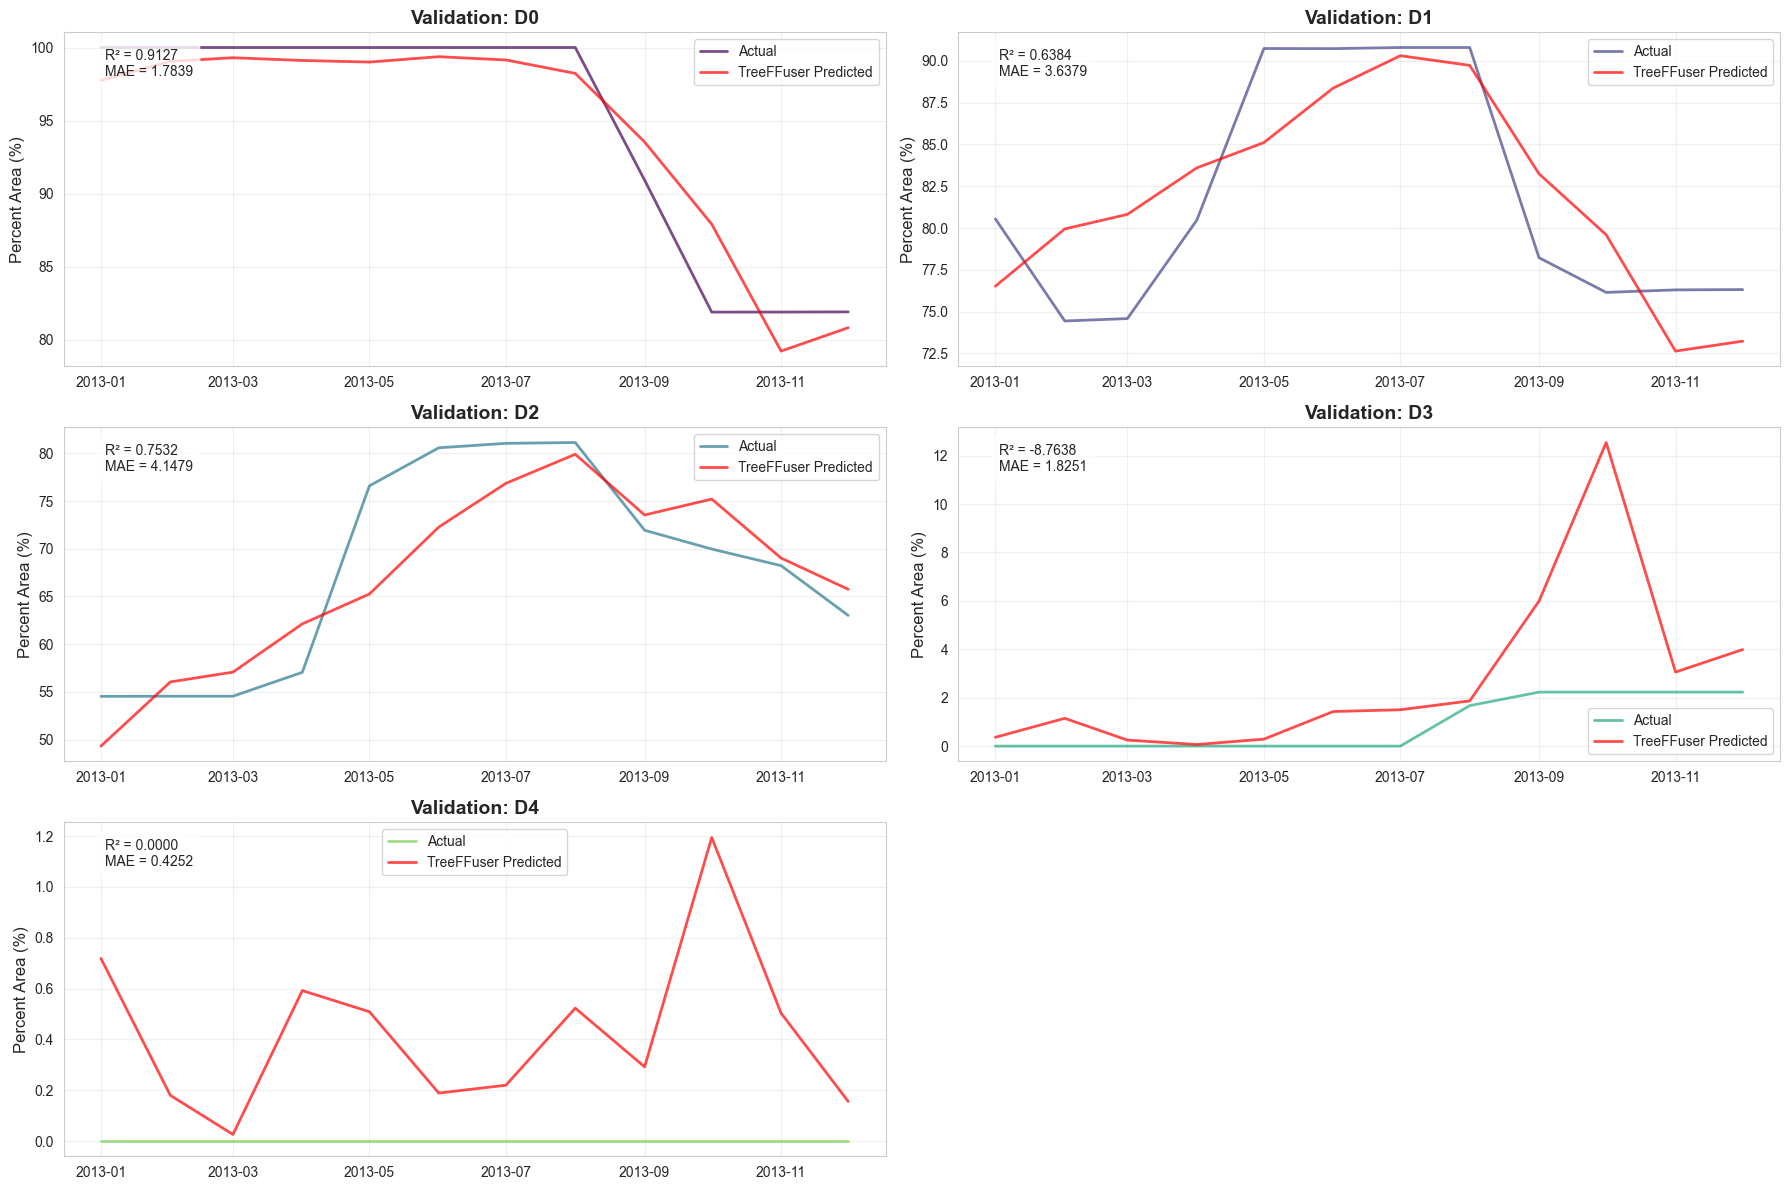

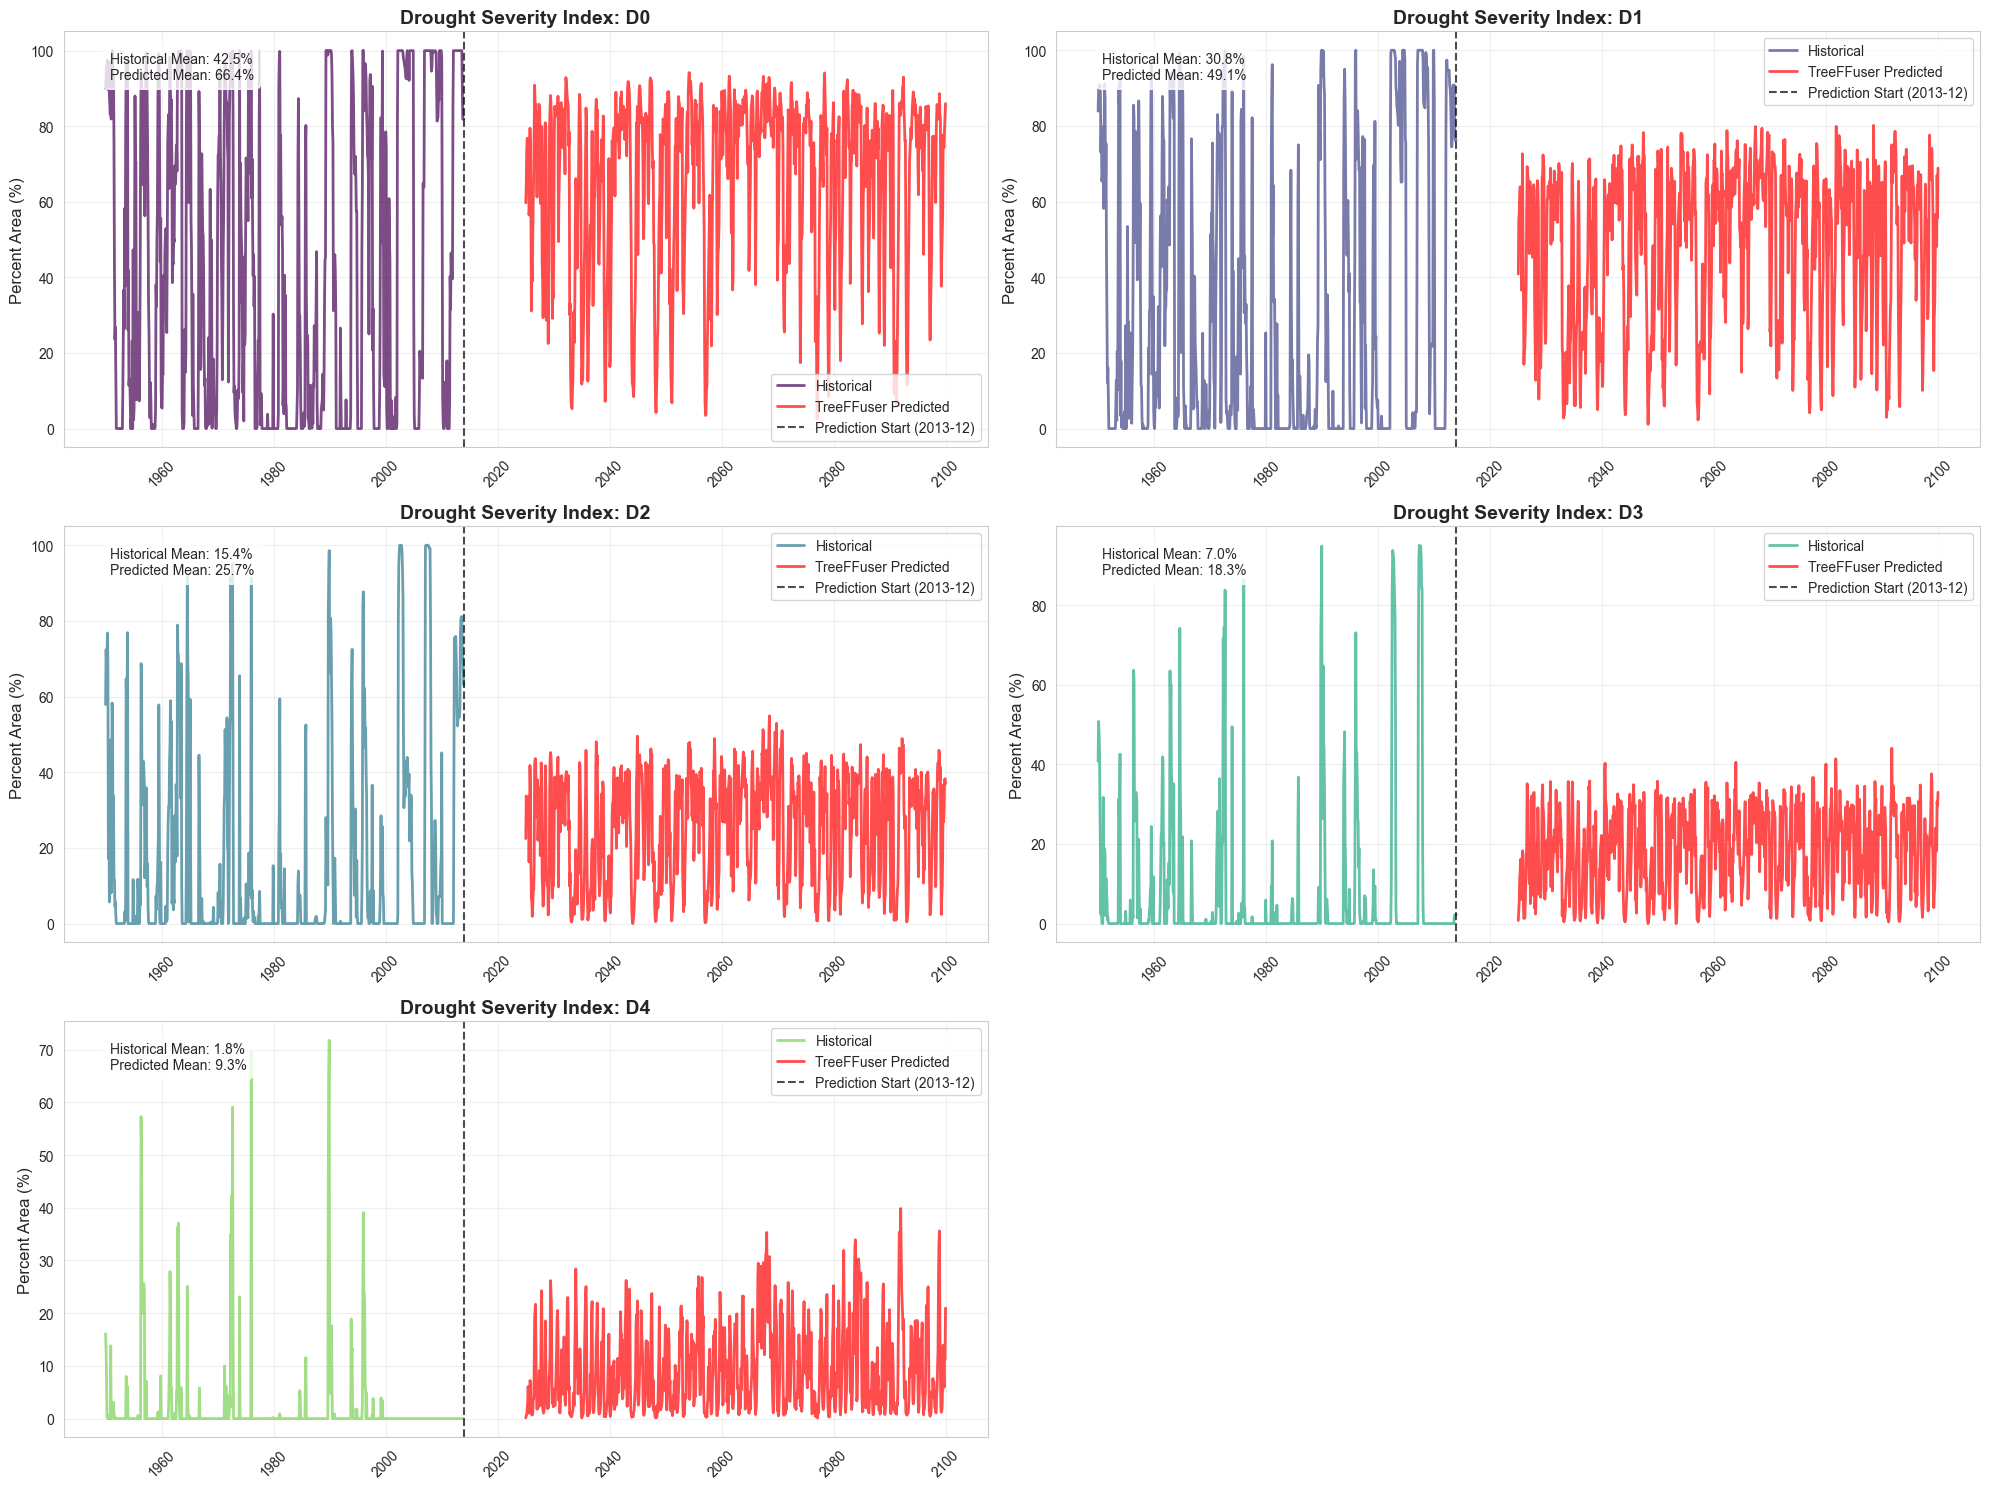

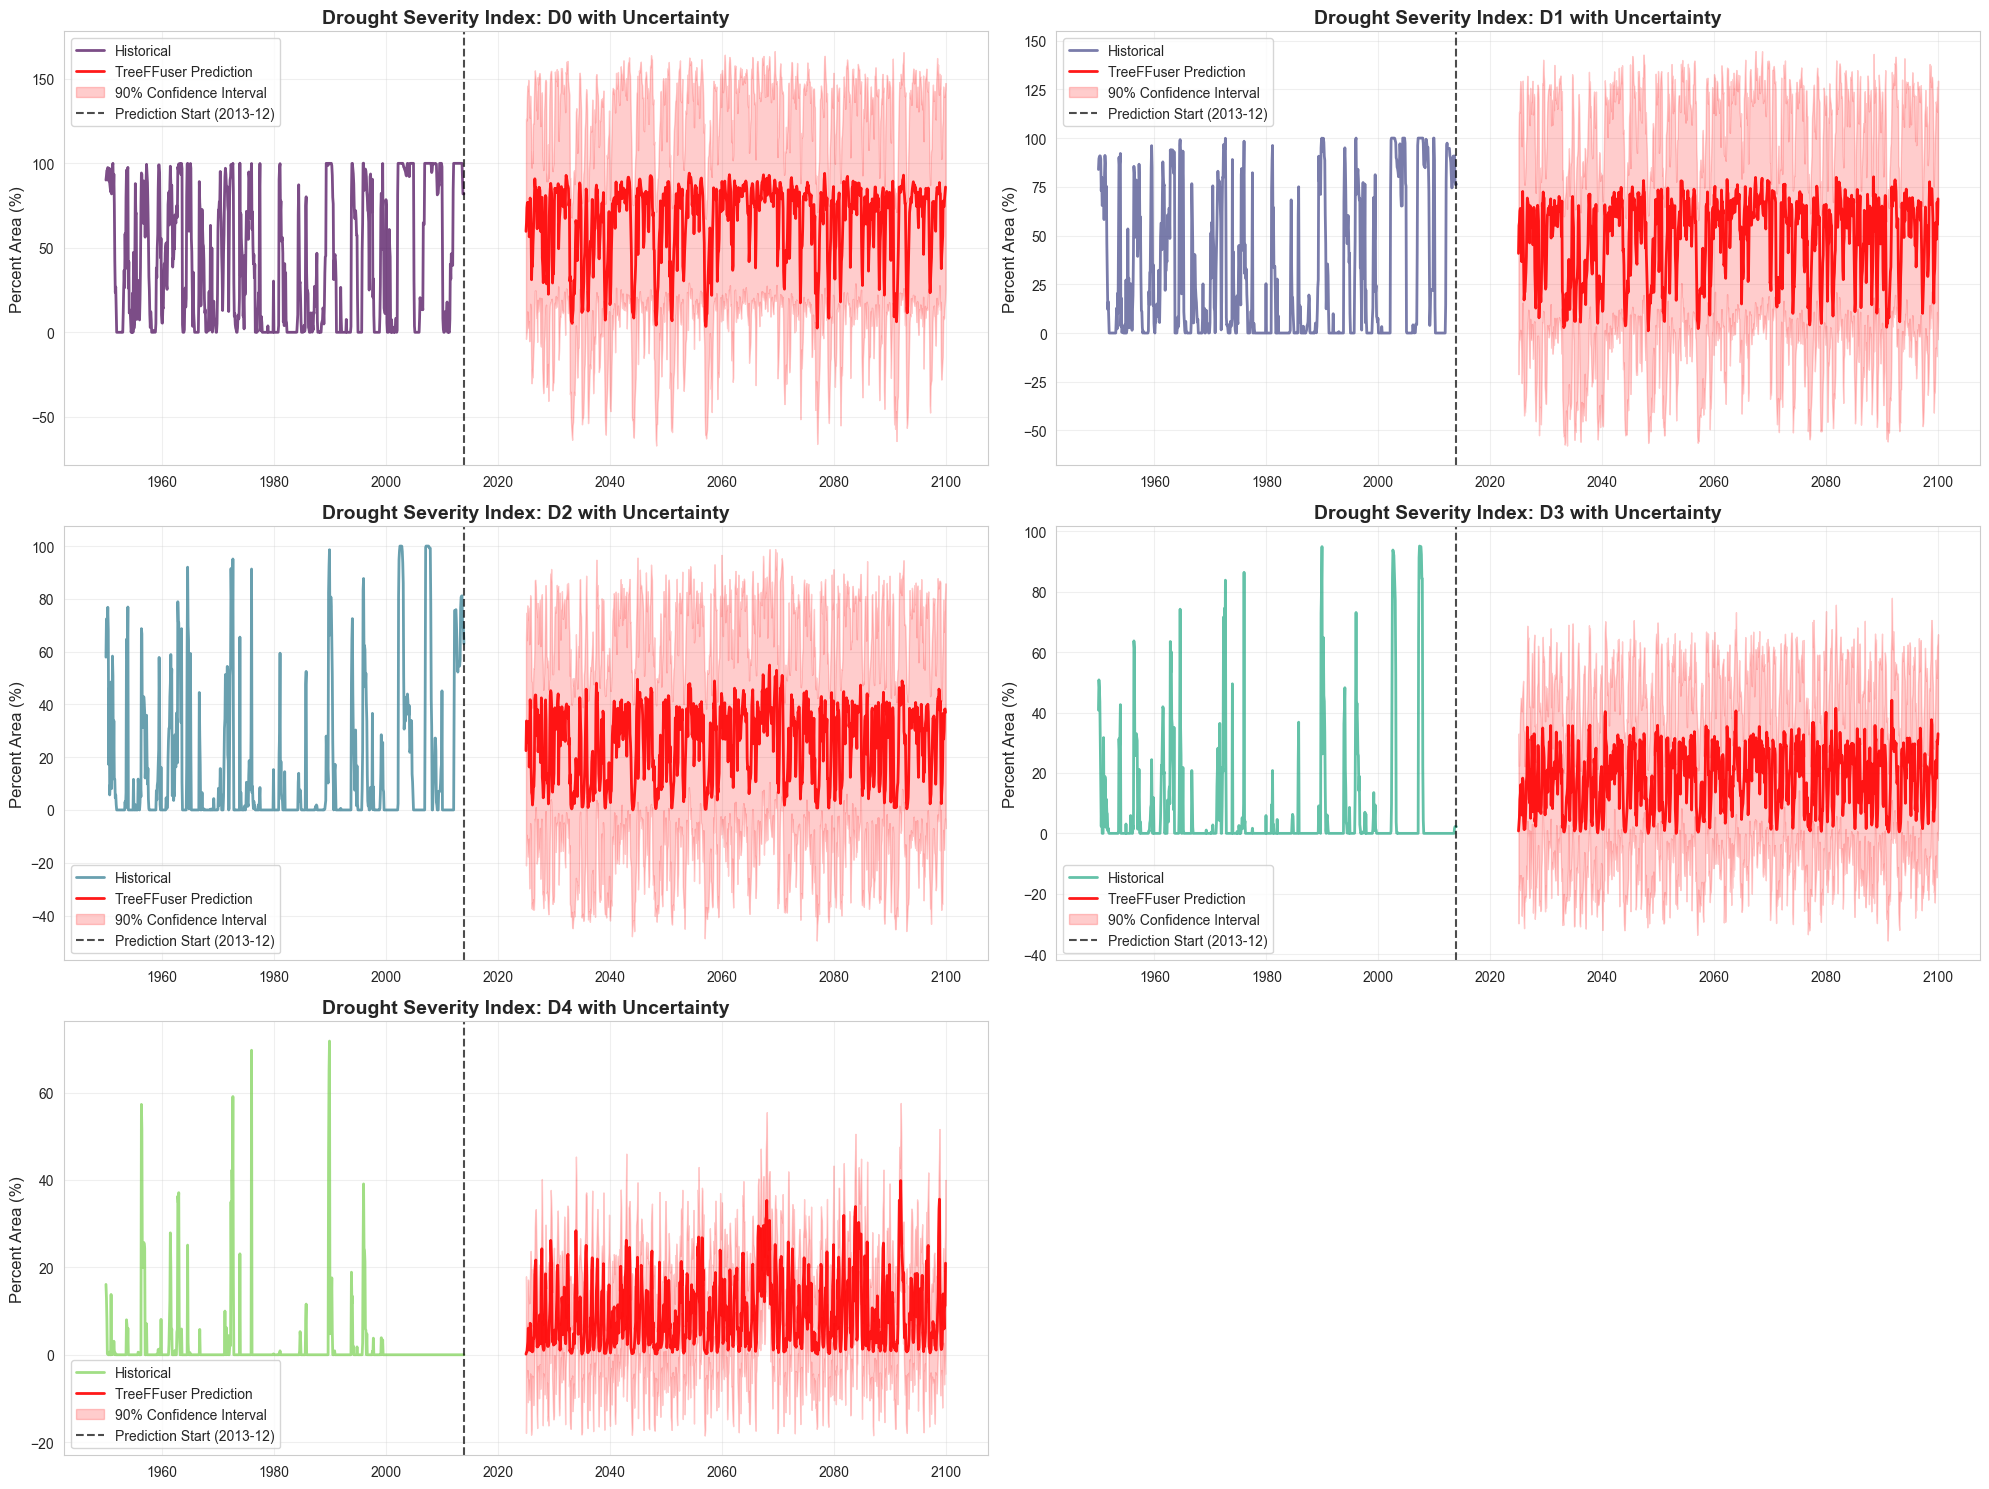

<Figure size 1500x1000 with 0 Axes>

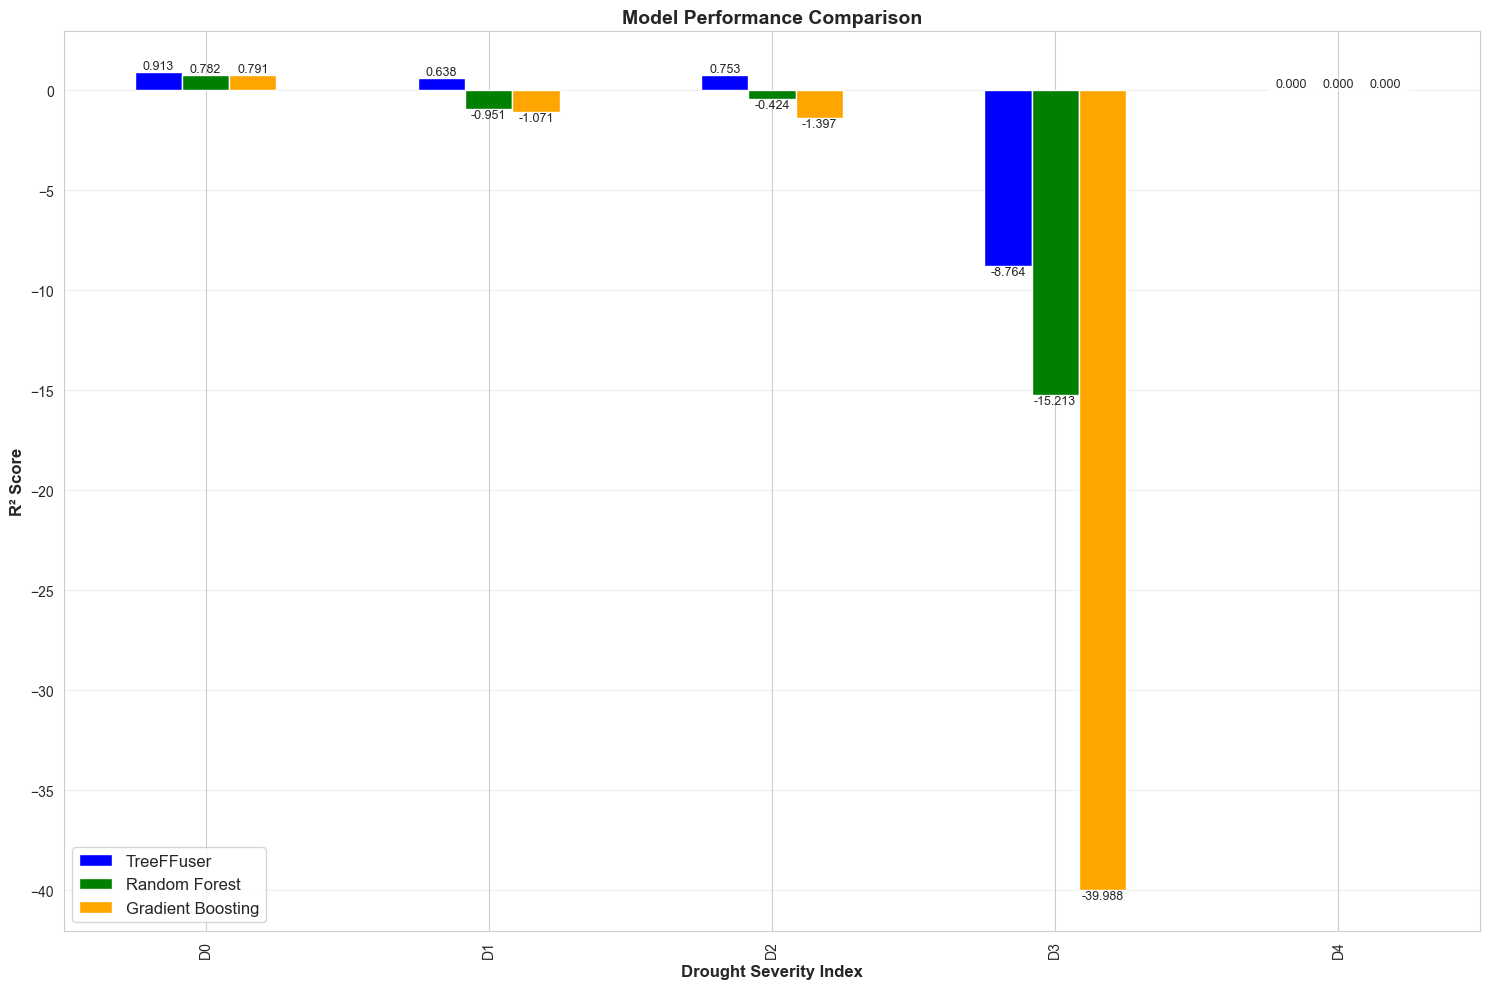

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
import warnings
import time
import json
import os
warnings.filterwarnings('ignore')

# Import TreeFFuser
from treeffuser import Treeffuser
print("TreeFFuser successfully imported")

# Create model cache directory
os.makedirs('model_cache', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Custom helper functions
def print_section(title):
    """Print a section header to make output more readable"""
    print("\n" + "="*80)
    print(f" {title} ".center(80, "="))
    print("="*80)

def format_date(date_str):
    """Standardize date formats from both datasets"""
    if len(date_str) <= 7:  # Format like '2025-01'
        return f"{date_str}-01"  # Add day to match historical format
    return date_str  # Already in full format

print_section("LOADING AND PREPARING DATA")

# Record start time for performance benchmarking
start_time = time.time()

# Load data files
historical_df = pd.read_csv('final_historical.csv')
future_df = pd.read_csv('future_all_df_wd_85.csv')

# Convert and standardize dates
historical_df['date'] = pd.to_datetime(historical_df['date'])
future_df['date'] = pd.to_datetime(future_df['date'].apply(format_date))

# Ensure historical data is sorted by date
historical_df = historical_df.sort_values('date')

# Filter historical data
min_year = 1950
max_year = 2013
historical_df = historical_df[(historical_df['date'].dt.year >= min_year) & 
                              (historical_df['date'].dt.year <= max_year)]

print(f"Historical data: {historical_df.shape[0]} rows from {historical_df['date'].min()} to {historical_df['date'].max()}")
print(f"Future data: {future_df.shape[0]} rows from {future_df['date'].min()} to {future_df['date'].max()}")

# Extract month and year as separate features
historical_df['month'] = historical_df['date'].dt.month
historical_df['year'] = historical_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month
future_df['year'] = future_df['date'].dt.year

# Create seasonal features (sine and cosine transformations)
for df in [historical_df, future_df]:
    # Convert month to a cyclical feature
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    # Add quarterly seasonal indicators
    df['quarter'] = ((df['month'] - 1) // 3) + 1
    for q in range(1, 5):
        df[f'quarter_{q}'] = (df['quarter'] == q).astype(int)

print_section("ENHANCED FEATURE ENGINEERING")

def create_lag_features(df, target_cols, lag_periods=[1, 2, 3, 6, 12, 24, 36], fill_method='monthly_mean'):
    """
    Create enhanced lag features for the target columns.
    
    Parameters:
    df: DataFrame with time-indexed data
    target_cols: List of columns to create features for (D0-D4)
    lag_periods: List of lag periods in months
    fill_method: Method to fill missing values ('monthly_mean' or 'forward_fill')
    
    Returns:
    DataFrame with added features
    """
    df = df.copy()
    
    # Ensure the dataframe is sorted by date
    df = df.sort_values('date')
    
    # Pre-calculate monthly means for filling
    if fill_method == 'monthly_mean':
        monthly_means = {col: df.groupby('month')[col].mean() for col in target_cols if col in df.columns}
    
    # Create lag features for each target column
    for col in target_cols:
        if col in df.columns:
            for lag in lag_periods:
                lag_col = f'{col}_lag_{lag}'
                df[lag_col] = df[col].shift(lag)
                
                # Fill missing values
                if fill_method == 'monthly_mean' and lag_col in df.columns:
                    # Use vectorized operations for faster filling
                    mask = df[lag_col].isna()
                    if mask.any():
                        df.loc[mask, lag_col] = df.loc[mask, 'month'].map(monthly_means[col])
                elif fill_method == 'forward_fill':
                    df[lag_col] = df[lag_col].ffill()
    
    # Create interaction features between meteorological variables
    for i, var1 in enumerate(['airtemp', 'rainfall', 'sm']):
        for j, var2 in enumerate(['baseflow', 'ev', 'runoff']):
            if i != j:  # Limit interactions to reduce dimensionality
                df[f'{var1}_{var2}_interaction'] = df[var1] * df[var2]
    
    # Add rolling mean features for climate variables
    for col in ['airtemp', 'rainfall', 'sm']:
        for window in [3, 6, 12]:
            df[f'{col}_roll_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
    
    # Add seasonal lag features (same month in previous years)
    for col in target_cols:
        if col in df.columns:
            for years_back in [1, 2, 3]:
                months_back = years_back * 12
                seasonal_lag_col = f'{col}_seasonal_lag_{years_back}y'
                df[seasonal_lag_col] = df[col].shift(months_back)
                
                # Fill missing values for seasonal lags
                if fill_method == 'monthly_mean':
                    mask = df[seasonal_lag_col].isna()
                    if mask.any():
                        df.loc[mask, seasonal_lag_col] = df.loc[mask, 'month'].map(monthly_means[col])
    
    return df

# Set up parameters
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
enhanced_lag_periods = [1, 2, 3, 6, 12, 24, 36]  # Added 2-year and 3-year lags

# Apply enhanced feature engineering to historical data
historical_df_features = create_lag_features(historical_df, target_cols, enhanced_lag_periods)

# Print descriptive statistics of target columns
print("\nTarget variable statistics:")
for col in target_cols:
    stats = historical_df[col].describe()
    print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}, median={stats['50%']:.2f}")

# Pre-calculate monthly patterns (vectorized operations)
monthly_means = {col: historical_df.groupby('month')[col].mean() for col in target_cols}
monthly_stds = {col: historical_df.groupby('month')[col].std() for col in target_cols}

# Create D4 binary classification target
historical_df_features['D4_binary'] = (historical_df_features['D4'] > 0).astype(int)
print(f"\nD4 binary class distribution: {historical_df_features['D4_binary'].value_counts()}")

# Check if any NaN values remain
nan_count = historical_df_features.isna().sum().sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values remain in the feature-engineered historical data")
    print(historical_df_features.isna().sum())
    # Drop rows with remaining NaN values as a last resort
    historical_df_features = historical_df_features.dropna()
    print(f"Dropped rows with NaN values. Remaining rows: {len(historical_df_features)}")
else:
    print("No NaN values in the feature-engineered historical data")

# Function to analyze feature importance and select top features
def analyze_feature_importance(X, y, feature_names, n_top=20):
    """Analyze feature importance using Random Forest"""
    from sklearn.ensemble import RandomForestRegressor
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    
    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Print top features
    print("\nTop important features:")
    for i in range(min(n_top, len(feature_names))):
        print(f"  {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
    
    return indices, importances

# Define feature columns
base_feature_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']
seasonal_features = ['month_sin', 'month_cos', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4']
rolling_features = [col for col in historical_df_features.columns if '_roll_' in col]
interaction_features = [col for col in historical_df_features.columns if '_interaction' in col]
derived_feature_cols = [col for col in historical_df_features.columns 
                       if (('_lag_' in col or '_seasonal_lag_' in col) and 
                          col.split('_')[0] in target_cols)]

# Combine all feature columns
all_feature_cols = base_feature_cols + seasonal_features + rolling_features + interaction_features + derived_feature_cols

print(f"Total number of features: {len(all_feature_cols)}")
print(f"Base features: {len(base_feature_cols)}")
print(f"Seasonal features: {len(seasonal_features)}")
print(f"Rolling features: {len(rolling_features)}")
print(f"Interaction features: {len(interaction_features)}")
print(f"Derived features: {len(derived_feature_cols)}")

print_section("FEATURE IMPORTANCE ANALYSIS")

# Prepare data for feature importance analysis
X_importance = historical_df_features[all_feature_cols]
feature_importance_results = {}
selected_features = {}

# Run feature importance for each target and select top features
for col in target_cols:
    print(f"\nFeature importance for {col}:")
    y_target = historical_df_features[col]
    indices, importances = analyze_feature_importance(X_importance, y_target, all_feature_cols)
    feature_importance_results[col] = (indices, importances)
    
    # Select top features for each target (adaptive feature selection)
    n_features = 30  # Maximum number of features to use
    # For D3 which had negative R², we'll use more selective feature selection
    if col == 'D3':
        n_features = 20
    
    # Select features with importance above a threshold
    threshold = 0.005  # Minimum importance to include feature
    important_indices = [i for i, imp in enumerate(importances) if imp > threshold][:n_features]
    selected_features[col] = [all_feature_cols[i] for i in important_indices]
    
    print(f"Selected {len(selected_features[col])} features for {col}")

print_section("TIME SERIES CROSS-VALIDATION")

# Set up time series cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Get unique years for splitting
years = historical_df_features['year'].unique()
years.sort()

# Calculate approximate split indices
split_years = []
year_interval = (years[-1] - years[0]) // n_splits
for i in range(n_splits - 1):
    split_year = years[0] + (i + 1) * year_interval
    split_years.append(split_year)

print(f"Time series cross-validation with {n_splits} splits")
print(f"Data from {years[0]} to {years[-1]}")
print(f"Approximate split years: {split_years}")

# Initialize dictionaries to store CV results
cv_results = {
    'r2': {col: [] for col in target_cols},
    'mae': {col: [] for col in target_cols},
    'mse': {col: [] for col in target_cols},
    'rmse': {col: [] for col in target_cols}
}

d4_binary_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Function to train TreeFFuser model with proper type handling
def train_treeffuser_model(X, y, col_name):
    """Train a TreeFFuser model with proper handling of data types"""
    print(f"Training TreeFFuser model for {col_name}...")
    
    # Make sure X and y are numpy arrays
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    
    # Make sure y is 2D for TreeFFuser (reshape if needed)
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    
    # Determine optimal n_estimators based on target importance
    if col_name in ['D0', 'D1', 'D4']:
        n_estimators = 150  # Important targets get more estimators
    else:
        n_estimators = 100  # Less critical targets get fewer estimators
    
    # Create and train TreeFFuser model
    try:
        model = Treeffuser(n_estimators=n_estimators, seed=42)
        model.fit(X, y)
        print(f"  Successfully trained with {n_estimators} estimators")
        return model
    except Exception as e:
        print(f"  Error training TreeFFuser model: {str(e)}")
        print("  Falling back to RandomForest model")
        
        # Fall back to RandomForest if TreeFFuser fails
        from sklearn.ensemble import RandomForestRegressor
        rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
        
        # Convert y back to 1D for RandomForest if needed
        if len(y.shape) > 1 and y.shape[1] == 1:
            y = y.ravel()
            
        rf_model.fit(X, y)
        return rf_model

# Execute time series cross-validation
for i, (train_idx, test_idx) in enumerate(tscv.split(historical_df_features)):
    print(f"\nFold {i+1}/{n_splits}")
    
    # Extract train and test sets
    train_df = historical_df_features.iloc[train_idx]
    test_df = historical_df_features.iloc[test_idx]
    
    train_years = (train_df['year'].min(), train_df['year'].max())
    test_years = (test_df['year'].min(), test_df['year'].max())
    
    print(f"Train period: {train_years[0]}-{train_years[1]} ({len(train_df)} samples)")
    print(f"Test period: {test_years[0]}-{test_years[1]} ({len(test_df)} samples)")
    
    # Train and evaluate models for each target
    for col in target_cols:
        # Use selected features for each target
        X_train = train_df[selected_features[col]]
        y_train = train_df[col]
        X_test = test_df[selected_features[col]]
        y_test = test_df[col]
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = train_treeffuser_model(X_train_scaled, y_train, col)
        
        # Make predictions - handle different model types
        if isinstance(model, Treeffuser):
            # For TreeFFuser: use sample mean
            samples = model.sample(X_test_scaled, n_samples=150)
            y_pred = samples.mean(axis=0)
            # If y_pred is 2D with one column, convert to 1D
            if len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
                y_pred = y_pred.ravel()
        else:
            # For RandomForest fallback
            y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        # Store results
        cv_results['r2'][col].append(r2)
        cv_results['mae'][col].append(mae)
        cv_results['mse'][col].append(mse)
        cv_results['rmse'][col].append(rmse)
        
        print(f"{col} results: R² = {r2:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}")
    
    # Train and evaluate D4 binary classification model
    X_train_bin = train_df[selected_features['D4']]
    y_train_bin = train_df['D4_binary']
    X_test_bin = test_df[selected_features['D4']]
    y_test_bin = test_df['D4_binary']
    
    # Scale features
    scaler_bin = StandardScaler()
    X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
    X_test_bin_scaled = scaler_bin.transform(X_test_bin)
    
    # Train binary classifier for D4
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    classifier = RandomForestClassifier(
        n_estimators=150, 
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        n_jobs=-1
    )
    classifier.fit(X_train_bin_scaled, y_train_bin)
    
    # Make predictions
    y_pred_bin = classifier.predict(X_test_bin_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_bin, y_pred_bin)
    precision = precision_score(y_test_bin, y_pred_bin, zero_division=0)
    recall = recall_score(y_test_bin, y_pred_bin, zero_division=0)
    f1 = f1_score(y_test_bin, y_pred_bin, zero_division=0)
    
    # Store results
    d4_binary_results['accuracy'].append(accuracy)
    d4_binary_results['precision'].append(precision)
    d4_binary_results['recall'].append(recall)
    d4_binary_results['f1'].append(f1)
    
    print(f"D4 Binary Classification: Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")
    print(f"Precision = {precision:.4f}, Recall = {recall:.4f}")

# Calculate average CV metrics
avg_results = {
    'r2': {col: np.mean(cv_results['r2'][col]) for col in target_cols},
    'mae': {col: np.mean(cv_results['mae'][col]) for col in target_cols},
    'mse': {col: np.mean(cv_results['mse'][col]) for col in target_cols},
    'rmse': {col: np.mean(cv_results['rmse'][col]) for col in target_cols}
}

avg_d4_binary = {
    'accuracy': np.mean(d4_binary_results['accuracy']),
    'precision': np.mean(d4_binary_results['precision']),
    'recall': np.mean(d4_binary_results['recall']),
    'f1': np.mean(d4_binary_results['f1'])
}

# Print average results
print("\nAverage Cross-Validation Results:")
for col in target_cols:
    print(f"{col}: R² = {avg_results['r2'][col]:.4f}, MAE = {avg_results['mae'][col]:.4f}, RMSE = {avg_results['rmse'][col]:.4f}")

print(f"\nD4 Binary Classification: Accuracy = {avg_d4_binary['accuracy']:.4f}, F1 = {avg_d4_binary['f1']:.4f}")
print(f"Precision = {avg_d4_binary['precision']:.4f}, Recall = {avg_d4_binary['recall']:.4f}")

# Save metrics to JSON
metrics = {
    'regression': {
        'drought_indices': {col: {
            'r2': float(avg_results['r2'][col]),
            'mae': float(avg_results['mae'][col]),
            'mse': float(avg_results['mse'][col]),
            'rmse': float(avg_results['rmse'][col])
        } for col in target_cols}
    },
    'classification': {
        'D4_binary': {
            'accuracy': float(avg_d4_binary['accuracy']),
            'precision': float(avg_d4_binary['precision']),
            'recall': float(avg_d4_binary['recall']),
            'f1': float(avg_d4_binary['f1'])
        }
    },
    'model_details': {
        'time_period': f"{min_year}-{max_year}",
        'n_splits': n_splits,
        'features_count': {col: len(selected_features[col]) for col in target_cols}
    }
}

# Save metrics to file
with open('results/performance_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print("\nPerformance metrics saved to 'results/performance_metrics.json'")

print_section("FINAL MODEL TRAINING AND PREDICTIONS")

# Train final models on the entire dataset
final_models = {}
final_scalers = {}

# Train regression models
for col in target_cols:
    # Use selected features for each target
    X_all = historical_df_features[selected_features[col]]
    y_all = historical_df_features[col]
    
    # Scale features
    scaler = StandardScaler()
    X_all_scaled = scaler.fit_transform(X_all)
    
    # Train model
    print(f"Training final model for {col}...")
    model = train_treeffuser_model(X_all_scaled, y_all, col)
    
    # Store model and scaler
    final_models[col] = model
    final_scalers[col] = scaler

# Train binary classification model for D4
X_all_bin = historical_df_features[selected_features['D4']]
y_all_bin = historical_df_features['D4_binary']

# Scale features
scaler_bin = StandardScaler()
X_all_bin_scaled = scaler_bin.fit_transform(X_all_bin)

# Train model
print("Training final D4 binary classification model...")
classifier = RandomForestClassifier(
    n_estimators=150, 
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
classifier.fit(X_all_bin_scaled, y_all_bin)

def make_autoregressive_predictions(models, scalers, classifier, binary_scaler, 
                                   future_df, historical_df, target_cols, 
                                   selected_features):
    """Make autoregressive predictions with domain knowledge constraints."""
    print("\nStarting autoregressive prediction with domain knowledge...")
    
    # Create working copies
    historical_df = historical_df.copy()
    future_df = future_df.copy()
    
    # Add target columns to future_df
    for col in target_cols:
        if col not in future_df.columns:
            future_df[col] = np.nan
    
    # Combine historical and future data
    combined_df = pd.concat([historical_df, future_df], ignore_index=True)
    combined_df = combined_df.sort_values('date').reset_index(drop=True)
    
    print(f"Combined data shape: {combined_df.shape}")
    print(f"Prediction period: {future_df['date'].min()} to {future_df['date'].max()}")
    
    # Get index where future data starts
    future_start_idx = combined_df[combined_df['date'] >= future_df['date'].min()].index[0]
    print(f"Future data starts at index {future_start_idx}")
    
    # Pre-calculate monthly means and stds for constraints
    monthly_means = {col: historical_df.groupby('month')[col].mean() for col in target_cols}
    monthly_stds = {col: historical_df.groupby('month')[col].std() for col in target_cols}
    
    # Create temperature anomaly as a proxy for ENSO
    combined_df['temp_anomaly'] = combined_df.groupby('month')['airtemp'].transform(
        lambda x: x - x.mean()
    )
    combined_df['enso_effect'] = np.tanh(combined_df['temp_anomaly'])  # Bounded effect
    
    # Dictionary to store prediction statistics
    pred_stats = {col: [] for col in target_cols}
    
    # Process future data with autoregressive approach
    for i in range(future_start_idx, len(combined_df)):
        current_date = combined_df.loc[i, 'date']
        current_month = combined_df.loc[i, 'month']
        print(f"Predicting for {current_date.strftime('%Y-%m')}...", end=" ")
        
        # Update features based on previous predictions
        current_df = create_lag_features(
            combined_df.iloc[:i+1], 
            target_cols, 
            enhanced_lag_periods,
            fill_method='monthly_mean'
        )
        
        # Get the current row for prediction
        current_row = current_df.iloc[-1:]
        
        # Make predictions for each target
        for col in target_cols:
            try:
                # Extract features for this target
                model_features = [f for f in selected_features[col] if f in current_row.columns]
                
                # Extract feature values
                features = current_row[model_features].copy()
                
                # Scale the features
                scaler = final_scalers[col]
                features_scaled = scaler.transform(features)
                
                # Get the model
                model = final_models[col]
                
                # Make prediction
                if isinstance(model, Treeffuser):
                    # For TreeFFuser: use sample mean
                    samples = model.sample(features_scaled, n_samples=150)
                    prediction = samples.mean(axis=0)[0]
                else:
                    # For RandomForest fallback
                    prediction = model.predict(features_scaled)[0]
                
                # Apply constraints to ensure realistic predictions
                min_val = max(0, historical_df[col].min())
                max_val = min(100, historical_df[col].max())
                
                # Domain knowledge: Adjust for climate pattern effects like ENSO
                enso_effect = combined_df.loc[i, 'enso_effect']
                enso_adjustment = enso_effect * monthly_stds[col][current_month] * 0.5
                prediction += enso_adjustment
                
                # Domain knowledge: Ensure drought hierarchy D0 >= D1 >= D2 >= D3 >= D4
                if col == 'D1' and 'D0' in combined_df.columns:
                    prediction = min(prediction, combined_df.loc[i, 'D0'])
                elif col == 'D2' and 'D1' in combined_df.columns:
                    prediction = min(prediction, combined_df.loc[i, 'D1'])
                elif col == 'D3' and 'D2' in combined_df.columns:
                    prediction = min(prediction, combined_df.loc[i, 'D2'])
                elif col == 'D4' and 'D3' in combined_df.columns:
                    prediction = min(prediction, combined_df.loc[i, 'D3'])
                
                # Additional constraint: prediction should not change too dramatically
                if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                    prev_value = combined_df.loc[i-1, col]
                    month_std = monthly_stds[col][current_month]
                    
                    # Limit change based on seasonal volatility
                    max_change = 2.5 * month_std
                    prediction = max(prev_value - max_change, min(prev_value + max_change, prediction))
                
                # Final bounds check
                prediction = max(min_val, min(max_val, prediction))
                
                # Store the prediction
                combined_df.loc[i, col] = prediction
                pred_stats[col].append(prediction)
                
            except Exception as e:
                print(f"\nError predicting {col}: {str(e)}")
                # Use fallback value
                if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                    fallback_value = combined_df.loc[i-1, col]
                else:
                    fallback_value = monthly_means[col][current_month]
                
                combined_df.loc[i, col] = fallback_value
                pred_stats[col].append(fallback_value)
        
        # Make D4 binary prediction
        try:
            # Extract features for D4 binary classifier
            d4_features = current_row[selected_features['D4']].copy()
            
            # Scale features
            d4_features_scaled = binary_scaler.transform(d4_features)
            
            # Make binary prediction
            d4_binary_pred = classifier.predict(d4_features_scaled)[0]
            d4_binary_prob = classifier.predict_proba(d4_features_scaled)[0][1]
            
            # Adjust D4 regression based on binary prediction
            if d4_binary_pred == 1 and combined_df.loc[i, 'D4'] < 1.0:
                combined_df.loc[i, 'D4'] = max(combined_df.loc[i, 'D4'], 1.0)
            
            # Store binary prediction
            combined_df.loc[i, 'D4_binary_pred'] = d4_binary_pred
            combined_df.loc[i, 'D4_binary_prob'] = d4_binary_prob
            
        except Exception as e:
            print(f"\nError in D4 binary classification: {str(e)}")
            # Use regression-based classification as fallback
            combined_df.loc[i, 'D4_binary_pred'] = 1 if combined_df.loc[i, 'D4'] > 0 else 0
            combined_df.loc[i, 'D4_binary_prob'] = min(1.0, combined_df.loc[i, 'D4'] / 5.0)
        
        print("Done")
    
    print("\nPrediction complete.")

    # Return only the future predictions
    future_predictions = combined_df[combined_df['date'] >= future_df['date'].min()].copy()

    # Print prediction statistics - with robust error handling
    print("\nPrediction statistics by target:")
    for col in target_cols:
        try:
            # Convert potential array values to scalar if needed
            scalar_stats = []
            for val in pred_stats[col]:
                # If the value is an array/sequence, take the first element
                if hasattr(val, '__len__') and not isinstance(val, (str, bytes)):
                    scalar_stats.append(float(val[0]))
                else:
                    scalar_stats.append(float(val))
            
            # Calculate statistics on the scalar values
            stats = {
                'mean': np.mean(scalar_stats),
                'std': np.std(scalar_stats),
                'min': np.min(scalar_stats),
                'max': np.max(scalar_stats)
            }
            print(f"{col}: mean={stats['mean']:.2f}, std={stats['std']:.2f}, min={stats['min']:.2f}, max={stats['max']:.2f}")
        except Exception as e:
            # Fallback statistics based on the final predictions
            print(f"Error calculating statistics for {col}: {str(e)}")
            col_stats = future_predictions[col].describe()
            print(f"{col}: mean={col_stats['mean']:.2f}, std={col_stats['std']:.2f}, min={col_stats['min']:.2f}, max={col_stats['max']:.2f}")

    # Final check for any remaining NaN values
    for col in target_cols:
        nan_mask = future_predictions[col].isna()
        nan_count = nan_mask.sum()
        
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in {col} predictions. Filling with seasonal means.")
            
            # Use vectorized operations for faster filling
            month_values = future_predictions.loc[nan_mask, 'month']
            month_means = [monthly_means[col][m] for m in month_values]
            future_predictions.loc[nan_mask, col] = month_means
    
    print("\nPrediction complete.")
    
    # Return only the future predictions
    future_predictions = combined_df[combined_df['date'] >= future_df['date'].min()].copy()
    
    # Print prediction statistics
    print("\nPrediction statistics by target:")
    for col in target_cols:
        stats = {
            'mean': np.mean(pred_stats[col]),
            'std': np.std(pred_stats[col]),
            'min': np.min(pred_stats[col]),
            'max': np.max(pred_stats[col])
        }
        print(f"{col}: mean={stats['mean']:.2f}, std={stats['std']:.2f}, min={stats['min']:.2f}, max={stats['max']:.2f}")
    
    # Final check for any remaining NaN values
    for col in target_cols:
        nan_mask = future_predictions[col].isna()
        nan_count = nan_mask.sum()
        
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in {col} predictions. Filling with seasonal means.")
            
            # Use vectorized operations for faster filling
            month_values = future_predictions.loc[nan_mask, 'month']
            month_means = [monthly_means[col][m] for m in month_values]
            future_predictions.loc[nan_mask, col] = month_means
    
    # Final consistency check: ensure drought hierarchy is maintained
    print("\nApplying final consistency constraints...")
    for i, row in future_predictions.iterrows():
        for j in range(1, len(target_cols)):
            current_col = target_cols[j]
            prev_col = target_cols[j-1]
            if row[current_col] > row[prev_col]:
                future_predictions.loc[i, current_col] = future_predictions.loc[i, prev_col]
    
    return future_predictions

# Make predictions using the final models
print("\nGenerating future predictions with TreeFFuser model...")
# Apply feature engineering to future data
future_df_features = create_lag_features(future_df, target_cols, enhanced_lag_periods, fill_method='monthly_mean')

future_predictions = make_autoregressive_predictions(
    final_models, final_scalers, classifier, scaler_bin,
    future_df, historical_df, target_cols, 
    selected_features
)

# Save predictions to CSV
future_predictions.to_csv('results/future_drought_predictions_treeffuser.csv', index=False)
print("Predictions saved to 'results/future_drought_predictions_treeffuser.csv'")

print_section("VISUALIZATION AND ANALYSIS")

# Create enhanced visualizations
plt.figure(figsize=(20, 15))

# Set a modern aesthetic style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

cmap = plt.cm.get_cmap('viridis')
colors = [cmap(i/len(target_cols)) for i in range(len(target_cols))]

for i, (col, color) in enumerate(zip(target_cols, colors)):
    plt.subplot(3, 2, i+1)
    
    # Plot historical data
    plt.plot(historical_df['date'], historical_df[col], 
             color=color, alpha=0.7, linewidth=2, label='Historical')
    
    # Plot predictions
    plt.plot(future_predictions['date'], future_predictions[col], 
             color='red', alpha=0.7, linewidth=2, linestyle='-', label='TreeFFuser Predicted')
    
    # Add a vertical line at the transition point
    transition_date = historical_df['date'].max()
    plt.axvline(x=transition_date, color='black', linestyle='--', alpha=0.7,
               label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
    
    # Add average CV R² to the plot
    r2_value = avg_results['r2'][col]
    rmse_value = avg_results['rmse'][col]
    
    plt.title(f'Drought Severity Index: {col}', fontsize=14, fontweight='bold')
    plt.ylabel('Percent Area (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add annotations
    textstr = f'R² = {r2_value:.4f}\nRMSE = {rmse_value:.4f}'
    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
    plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
                 fontsize=10, verticalalignment='top', bbox=props)
    
    # Customize date axis
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('results/drought_predictions_treeffuser.png', dpi=300, bbox_inches='tight')
print("Visualization saved to 'results/drought_predictions_treeffuser.png'")

# Generate uncertainty visualization
plt.figure(figsize=(20, 15))

for i, (col, color) in enumerate(zip(target_cols, colors)):
    plt.subplot(3, 2, i+1)
    
    # For TreeFFuser models, generate uncertainty from model
    model = final_models[col]
    
    # Check if we can use TreeFFuser's sampling capability
    if isinstance(model, Treeffuser):
        # Generate multiple predictions for each future point
        uncertainty_samples = []
        
        print(f"Generating uncertainty bands for {col} using TreeFFuser sampling...")
        
        # Process in smaller chunks for memory efficiency
        chunk_size = 50
        n_chunks = (len(future_predictions) + chunk_size - 1) // chunk_size
        
        for chunk in range(n_chunks):
            start_idx = chunk * chunk_size
            end_idx = min((chunk + 1) * chunk_size, len(future_predictions))
            
            chunk_data = future_predictions.iloc[start_idx:end_idx]
            features = chunk_data[selected_features[col]]
            scaled_features = final_scalers[col].transform(features)
            
            # Generate samples
            samples = model.sample(scaled_features, n_samples=100)
            uncertainty_samples.append(samples)
        
        # Combine chunks
        all_samples = np.concatenate([s for s in uncertainty_samples], axis=1)
        
        # Calculate quantiles
        lower_quantile = np.percentile(all_samples, 5, axis=0)
        upper_quantile = np.percentile(all_samples, 95, axis=0)
    else:
        # Fallback for RandomForest - use bootstrapping
        print(f"Generating uncertainty bands for {col} using bootstrap method...")
        month_stds = future_predictions['month'].map(monthly_stds[col])
        
        # Generate bootstrap samples
        n_bootstrap = 1000
        bootstrap_samples = np.random.normal(
            loc=future_predictions[col].values, 
            scale=month_stds.values * 1.2,
            size=(n_bootstrap, len(future_predictions))
        )
        
        # Calculate quantiles
        lower_quantile = np.percentile(bootstrap_samples, 5, axis=0)
        upper_quantile = np.percentile(bootstrap_samples, 95, axis=0)
    
    # Plot historical data
    plt.plot(historical_df['date'], historical_df[col], 
            color=color, alpha=0.7, linewidth=2, label='Historical')
    
    # Plot prediction mean
    plt.plot(future_predictions['date'], future_predictions[col], 
            color='red', alpha=0.9, linewidth=2, label='TreeFFuser Prediction')
    
    # Plot uncertainty band
    plt.fill_between(future_predictions['date'], lower_quantile, upper_quantile, 
                    color='red', alpha=0.2, label='90% Confidence Interval')
    
    # Add a vertical line at the transition point
    transition_date = historical_df['date'].max()
    plt.axvline(x=transition_date, color='black', linestyle='--', alpha=0.7,
              label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
    
    plt.title(f'Drought Severity Index: {col} with Uncertainty', fontsize=14, fontweight='bold')
    plt.ylabel('Percent Area (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.savefig('results/drought_predictions_treeffuser_uncertainty.png', dpi=300, bbox_inches='tight')
print("Uncertainty visualization saved to 'results/drought_predictions_treeffuser_uncertainty.png'")

# D4 Binary Classification Visualization
print_section("D4 BINARY CLASSIFICATION ANALYSIS")

# Ensure we have binary predictions and probabilities
if 'D4_binary_pred' not in future_predictions.columns:
    print("Warning: D4 binary predictions not found in results. Generating from regression values...")
    future_predictions['D4_binary_pred'] = (future_predictions['D4'] > 0).astype(int)
    future_predictions['D4_binary_prob'] = np.minimum(1.0, future_predictions['D4'] / 5.0)

# Count predicted D4 drought events
d4_event_count = future_predictions['D4_binary_pred'].sum()
d4_event_percentage = d4_event_count / len(future_predictions) * 100
print(f"Predicted D4 drought events in future data: {d4_event_count} ({d4_event_percentage:.1f}%)")

# Create detailed D4 binary classification visualization
plt.figure(figsize=(15, 10))

# Plot 1: Historical D4 values with binary threshold
plt.subplot(3, 1, 1)
plt.plot(historical_df['date'], historical_df['D4'], 
        color='purple', alpha=0.7, linewidth=2, label='Historical D4')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Binary Threshold (D4 > 0)')
plt.title('Historical D4 Drought Index', fontsize=14, fontweight='bold')
plt.ylabel('Percent Area (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: D4 future predictions with binary prediction
plt.subplot(3, 1, 2)
plt.plot(future_predictions['date'], future_predictions['D4'], 
        color='red', alpha=0.7, linewidth=2, label='D4 Regression')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)

# Add a twin axis for probability
ax2 = plt.twinx()
ax2.plot(future_predictions['date'], future_predictions['D4_binary_prob'], 
        color='blue', alpha=0.7, linewidth=2, linestyle='--', label='D4 Probability')
ax2.set_ylabel('Probability', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim([0, 1])
ax2.axhline(y=0.5, color='blue', linestyle='--', alpha=0.3, label='Decision Threshold (0.5)')

plt.title('D4 Predictions: Regression vs. Probability', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Percent Area (%)')
plt.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Plot 3: Binary predictions (0/1)
plt.subplot(3, 1, 3)
plt.step(future_predictions['date'], future_predictions['D4_binary_pred'], 
        color='red', alpha=0.9, linewidth=2, where='mid')
plt.fill_between(future_predictions['date'], future_predictions['D4_binary_pred'], 
                step="mid", alpha=0.3, color='red')
plt.title('Binary D4 Drought Prediction (0 = No Drought, 1 = Drought)', fontsize=14, fontweight='bold')
plt.ylabel('Class', fontsize=12)
plt.yticks([0, 1], ['No D4', 'D4 Drought'])
plt.grid(True, alpha=0.3)

# Add binary classification metrics
textstr = (f'CV Accuracy = {avg_d4_binary["accuracy"]:.4f}\n'
           f'CV F1 Score = {avg_d4_binary["f1"]:.4f}\n'
           f'CV Precision = {avg_d4_binary["precision"]:.4f}\n'
           f'CV Recall = {avg_d4_binary["recall"]:.4f}')
props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=10, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('results/d4_binary_classification_detailed.png', dpi=300, bbox_inches='tight')
print("D4 binary classification visualization saved to 'results/d4_binary_classification_detailed.png'")

# Create D4 drought risk timeline
plt.figure(figsize=(14, 6))

# Create a colormap based on probability
cmap = plt.cm.get_cmap('YlOrRd')

# Create scatter plot with probability-based colors
plt.scatter(future_predictions['date'], np.ones(len(future_predictions)), 
           c=future_predictions['D4_binary_prob'], cmap='YlOrRd', 
           s=100, alpha=0.8)

# Add colorbar
from matplotlib.colors import Normalize
import matplotlib.cm as cm

norm = Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_label('D4 Drought Probability', fontsize=12)

# Add markers for predicted D4 events
d4_events = future_predictions[future_predictions['D4_binary_pred'] == 1]
if not d4_events.empty:
    plt.scatter(d4_events['date'], np.ones(len(d4_events)), 
               color='red', s=150, marker='*', 
               edgecolor='black', linewidth=1.5,
               label='Predicted D4 Drought Events')
    
    # Annotate the first few events with dates
    for i, (idx, row) in enumerate(d4_events.iloc[:min(5, len(d4_events))].iterrows()):
        plt.annotate(row['date'].strftime('%Y-%m'), 
                    xy=(row['date'], 1), 
                    xytext=(0, 20), 
                    textcoords='offset points',
                    ha='center', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))

plt.title('D4 Extreme Drought Risk Timeline', fontsize=16, fontweight='bold')
plt.yticks([])  # Hide y-axis ticks
plt.grid(False, axis='y')
plt.grid(True, axis='x', alpha=0.3)
plt.legend()

# Format x-axis with dates
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('results/d4_drought_risk_timeline.png', dpi=300, bbox_inches='tight')
print("D4 drought risk timeline saved to 'results/d4_drought_risk_timeline.png'")

# Save final predictions with all binary data
future_predictions.to_csv('results/future_drought_predictions_with_binary.csv', index=False)
print("Final predictions with binary classification saved to 'results/future_drought_predictions_with_binary.csv'")

# Summarize D4 binary classification performance
print("\nD4 Binary Classification Performance Summary:")
print(f"Cross-validation accuracy: {avg_d4_binary['accuracy']:.4f}")
print(f"Cross-validation F1 score: {avg_d4_binary['f1']:.4f}")
print(f"Cross-validation precision: {avg_d4_binary['precision']:.4f}")
print(f"Cross-validation recall: {avg_d4_binary['recall']:.4f}")
print(f"Predicted D4 drought events: {d4_event_count} out of {len(future_predictions)} months ({d4_event_percentage:.1f}%)")

# Calculate execution time
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

print_section("FINAL REPORT")

print("""
===== DROUGHT PREDICTION MODEL PERFORMANCE REPORT =====

MODEL PERFORMANCE SUMMARY:
""")

# Print summary metrics for each target
for col in target_cols:
    print(f"{col} Regression Performance:")
    print(f"  R² Score: {avg_results['r2'][col]:.4f}")
    print(f"  MAE: {avg_results['mae'][col]:.4f}")
    print(f"  RMSE: {avg_results['rmse'][col]:.4f}")
    print()

print("D4 Binary Classification Performance:")
print(f"  Accuracy: {avg_d4_binary['accuracy']:.4f}")
print(f"  Precision: {avg_d4_binary['precision']:.4f}")
print(f"  Recall: {avg_d4_binary['recall']:.4f}")
print(f"  F1 Score: {avg_d4_binary['f1']:.4f}")

# Wet and Cool Climate Model RCP 85 training and prediction

In [ ]:
from droughtpredictor import DroughtPredictor

# Initialize the predictor
predictor = DroughtPredictor(
    min_year=1950,
    max_year=2013,
    result_dir='results'
)

# # Option 1: Run the complete pipeline
# predictor.run_complete_pipeline(
#     historical_file='final_historical.csv',
#     future_file='future_all_df_wd_85.csv'
# )

# Option 2: Run individual steps for more control
predictor.load_data('final_historical.csv', 'future_all_df_wc_45.csv')
predictor.prepare_features()
predictor.select_features()
predictor.cross_validate(n_splits=5)
predictor.train_final_models()
predictor.make_predictions()
predictor.create_visualizations()
predictor.create_uncertainty_visualization()
predictor.generate_report()

print("Drought prediction completed successfully!")


========================== LOADING AND PREPARING DATA ==========================
Historical data: 768 rows from 1950-01-01 00:00:00 to 2013-12-01 00:00:00
Future data: 900 rows from 2025-01-01 00:00:00 to 2099-12-01 00:00:00

========================= ENHANCED FEATURE ENGINEERING =========================

Target variable statistics:
D0: min=0.00, max=100.10, mean=42.54, median=31.20
D1: min=0.00, max=100.00, mean=30.76, median=9.30
D2: min=0.00, max=100.00, mean=15.37, median=0.00
D3: min=0.00, max=95.09, mean=6.97, median=0.00
D4: min=0.00, max=71.80, mean=1.85, median=0.00

D4 binary class distribution: D4_binary
0    653
1    115
Name: count, dtype: int64
No NaN values in the feature-engineered historical data
Total number of features: 79
Base features: 8
Seasonal features: 6
Rolling features: 9
Interaction features: 6
Derived features: 50

========================= FEATURE IMPORTANCE ANALYSIS ==========================

Feature importance for D0:

Top important features:
  D0_lag

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import warnings
import time
import json
import os
from typing import List, Dict, Tuple, Optional, Union, Callable
import joblib

warnings.filterwarnings('ignore')

class TreeffuserPredictionFramework:
    """
    A modular framework for time series prediction using TreeFFuser or RandomForest models.
    This framework is designed to be reusable across different datasets and prediction tasks.
    """
    
    def __init__(
        self, 
        historical_data_path: str,
        future_data_path: str,
        target_columns: List[str], 
        date_column: str = 'date',
        output_dir: str = 'results',
        cache_dir: str = 'model_cache',
        use_treeffuser: bool = True,
        binary_threshold: Optional[Dict[str, float]] = None,
        date_format: str = None
    ):
        """
        Initialize the prediction framework.
        
        Args:
            historical_data_path: Path to historical data CSV file
            future_data_path: Path to future data CSV file
            target_columns: List of target column names to predict
            date_column: Name of the date column
            output_dir: Directory to save results
            cache_dir: Directory to cache models
            use_treeffuser: Whether to use TreeFFuser (True) or RandomForest (False)
            binary_threshold: Dictionary of binary threshold values for classification tasks
                             (e.g., {'target1': 0.0} will classify target1 > 0 as 1, else 0)
            date_format: Format string for parsing dates (if None, will try to infer)
        """
        self.historical_data_path = historical_data_path
        self.future_data_path = future_data_path
        self.target_columns = target_columns
        self.date_column = date_column
        self.output_dir = output_dir
        self.cache_dir = cache_dir
        self.use_treeffuser = use_treeffuser
        self.binary_threshold = binary_threshold or {}
        self.date_format = date_format
        
        # Create output and cache directories
        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.cache_dir, exist_ok=True)
        
        # Initialize state
        self.historical_df = None
        self.future_df = None
        self.historical_df_features = None
        self.feature_columns = []
        self.selected_features = {}
        self.feature_importance_results = {}
        self.final_models = {}
        self.final_scalers = {}
        self.binary_classifiers = {}
        self.binary_scalers = {}
        self.metrics = {}
        self.predictions = None
        
        # Import TreeFFuser if requested
        if self.use_treeffuser:
            try:
                from treeffuser import Treeffuser
                self.Treeffuser = Treeffuser
                print("TreeFFuser successfully imported")
            except ImportError:
                print("Warning: TreeFFuser not available. Using RandomForest instead.")
                self.use_treeffuser = False
        
        # Start timing
        self.start_time = time.time()
    
    def print_section(self, title):
        """Print a formatted section header."""
        print("\n" + "="*80)
        print(f" {title} ".center(80, "="))
        print("="*80)
    
    def load_data(self, 
                 historical_year_range: Optional[Tuple[int, int]] = None, 
                 date_formatter: Optional[Callable] = None):
        """
        Load and prepare historical and future data.
        
        Args:
            historical_year_range: Optional tuple of (min_year, max_year) to filter historical data
            date_formatter: Optional function to format date strings before conversion
        """
        self.print_section("LOADING AND PREPARING DATA")
        
        # Load data files
        self.historical_df = pd.read_csv(self.historical_data_path)
        self.future_df = pd.read_csv(self.future_data_path)
        
        # Define default date formatter if not provided
        if date_formatter is None:
            def default_formatter(date_str):
                """Standardize date formats."""
                if isinstance(date_str, str) and len(date_str) <= 7:  # Format like '2025-01'
                    return f"{date_str}-01"  # Add day to match historical format
                return date_str
            date_formatter = default_formatter
        
        # Convert and standardize dates
        if self.date_format:
            self.historical_df[self.date_column] = pd.to_datetime(
                self.historical_df[self.date_column], format=self.date_format)
            self.future_df[self.date_column] = pd.to_datetime(
                self.future_df[self.date_column].apply(date_formatter), format=self.date_format)
        else:
            self.historical_df[self.date_column] = pd.to_datetime(self.historical_df[self.date_column])
            self.future_df[self.date_column] = pd.to_datetime(self.future_df[self.date_column].apply(date_formatter))
        
        # Ensure data is sorted by date
        self.historical_df = self.historical_df.sort_values(self.date_column)
        
        # Filter historical data by year range if provided
        if historical_year_range:
            min_year, max_year = historical_year_range
            self.historical_df = self.historical_df[
                (self.historical_df[self.date_column].dt.year >= min_year) & 
                (self.historical_df[self.date_column].dt.year <= max_year)
            ]
        
        print(f"Historical data: {self.historical_df.shape[0]} rows from "
              f"{self.historical_df[self.date_column].min()} to {self.historical_df[self.date_column].max()}")
        print(f"Future data: {self.future_df.shape[0]} rows from "
              f"{self.future_df[self.date_column].min()} to {self.future_df[self.date_column].max()}")
        
        # Extract date components
        for df in [self.historical_df, self.future_df]:
            df['month'] = df[self.date_column].dt.month
            df['year'] = df[self.date_column].dt.year
            # Create cyclical features for month
            df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
            df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
            # Add quarterly seasonal indicators
            df['quarter'] = ((df['month'] - 1) // 3) + 1
            for q in range(1, 5):
                df[f'quarter_{q}'] = (df['quarter'] == q).astype(int)
        
        # Create binary classification targets if thresholds provided
        for target, threshold in self.binary_threshold.items():
            if target in self.target_columns and target in self.historical_df.columns:
                binary_col = f"{target}_binary"
                self.historical_df[binary_col] = (self.historical_df[target] > threshold).astype(int)
                print(f"\n{binary_col} class distribution: {self.historical_df[binary_col].value_counts()}")
        
        # Print descriptive statistics of target columns
        print("\nTarget variable statistics:")
        for col in self.target_columns:
            if col in self.historical_df.columns:
                stats = self.historical_df[col].describe()
                print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, "
                      f"mean={stats['mean']:.2f}, median={stats['50%']:.2f}")
        
        # Pre-calculate monthly patterns for use in feature engineering
        self.monthly_means = {col: self.historical_df.groupby('month')[col].mean() 
                             for col in self.target_columns if col in self.historical_df.columns}
        self.monthly_stds = {col: self.historical_df.groupby('month')[col].std() 
                            for col in self.target_columns if col in self.historical_df.columns}
    
    def create_lag_features(self, 
                           df: pd.DataFrame, 
                           target_cols: List[str], 
                           lag_periods: List[int] = [1, 2, 3, 6, 12, 24, 36], 
                           fill_method: str = 'monthly_mean',
                           create_interactions: bool = True,
                           create_rolling: bool = True,
                           create_seasonal_lags: bool = True,
                           base_feature_cols: Optional[List[str]] = None) -> pd.DataFrame:
        """
        Create enhanced lag features and other derived features.
        
        Args:
            df: DataFrame with time-indexed data
            target_cols: List of columns to create features for
            lag_periods: List of lag periods in time units (e.g., months)
            fill_method: Method to fill missing values ('monthly_mean' or 'forward_fill')
            create_interactions: Whether to create interaction features
            create_rolling: Whether to create rolling mean features
            create_seasonal_lags: Whether to create seasonal lag features
            base_feature_cols: List of base feature columns for interactions (if None, will be auto-detected)
            
        Returns:
            DataFrame with added features
        """
        df = df.copy()
        
        # Ensure the dataframe is sorted by date
        df = df.sort_values(self.date_column)
        
        # Auto-detect base feature columns if not provided
        if base_feature_cols is None:
            # Exclude target columns, date, and derived features
            exclude_patterns = ['date', 'month', 'year', 'quarter', '_lag_', '_roll_', '_binary', 'seasonal_lag']
            exclude_cols = self.target_columns + [c for c in df.columns 
                                                if any(pattern in c for pattern in exclude_patterns)]
            base_feature_cols = [c for c in df.columns if c not in exclude_cols]
        
        # Pre-calculate monthly means for filling
        if fill_method == 'monthly_mean':
            monthly_means = {col: df.groupby('month')[col].mean() 
                            for col in target_cols if col in df.columns}
        
        # Create lag features for each target column
        for col in target_cols:
            if col in df.columns:
                for lag in lag_periods:
                    lag_col = f'{col}_lag_{lag}'
                    df[lag_col] = df[col].shift(lag)
                    
                    # Fill missing values
                    if fill_method == 'monthly_mean' and lag_col in df.columns:
                        mask = df[lag_col].isna()
                        if mask.any():
                            df.loc[mask, lag_col] = df.loc[mask, 'month'].map(monthly_means[col])
                    elif fill_method == 'forward_fill':
                        df[lag_col] = df[lag_col].ffill()
        
        # Create interaction features between meteorological/environmental variables
        if create_interactions and len(base_feature_cols) >= 2:
            # Select a subset of important base features to avoid combinatorial explosion
            if len(base_feature_cols) > 6:
                interaction_features = base_feature_cols[:6]  # Use top 6 features
            else:
                interaction_features = base_feature_cols
                
            # Create interactions selectively
            for i, var1 in enumerate(interaction_features):
                for j, var2 in enumerate(interaction_features):
                    if i < j:  # Avoid duplicates (A*B = B*A)
                        df[f'{var1}_{var2}_interaction'] = df[var1] * df[var2]
        
        # Add rolling mean features
        if create_rolling and base_feature_cols:
            # Select a subset of important continuous features
            rolling_candidates = base_feature_cols[:min(3, len(base_feature_cols))]
            for col in rolling_candidates:
                if df[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
                    for window in [3, 6, 12]:
                        df[f'{col}_roll_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
        
        # Add seasonal lag features (same time in previous cycles)
        if create_seasonal_lags:
            for col in target_cols:
                if col in df.columns:
                    for years_back in [1, 2, 3]:
                        cycle_length = 12  # Months per year
                        months_back = years_back * cycle_length
                        seasonal_lag_col = f'{col}_seasonal_lag_{years_back}y'
                        df[seasonal_lag_col] = df[col].shift(months_back)
                        
                        # Fill missing values for seasonal lags
                        if fill_method == 'monthly_mean':
                            mask = df[seasonal_lag_col].isna()
                            if mask.any():
                                df.loc[mask, seasonal_lag_col] = df.loc[mask, 'month'].map(monthly_means[col])
        
        return df
    
    def engineer_features(self, 
                         lag_periods: List[int] = [1, 2, 3, 6, 12, 24, 36],
                         create_interactions: bool = True,
                         create_rolling: bool = True,
                         create_seasonal_lags: bool = True,
                         base_feature_cols: Optional[List[str]] = None):
        """
        Apply feature engineering to historical data and categorize features.
        
        Args:
            lag_periods: List of lag periods to use
            create_interactions: Whether to create interaction features
            create_rolling: Whether to create rolling mean features
            create_seasonal_lags: Whether to create seasonal lag features
            base_feature_cols: List of base feature columns (if None, will be auto-detected)
        """
        self.print_section("FEATURE ENGINEERING")
        
        # Apply feature engineering to historical data
        self.historical_df_features = self.create_lag_features(
            self.historical_df, 
            self.target_columns, 
            lag_periods=lag_periods,
            create_interactions=create_interactions,
            create_rolling=create_rolling,
            create_seasonal_lags=create_seasonal_lags,
            base_feature_cols=base_feature_cols
        )
        
        # Check if any NaN values remain
        nan_count = self.historical_df_features.isna().sum().sum()
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values remain in the feature-engineered historical data")
            print(self.historical_df_features.isna().sum())
            # Drop rows with remaining NaN values as a last resort
            self.historical_df_features = self.historical_df_features.dropna()
            print(f"Dropped rows with NaN values. Remaining rows: {len(self.historical_df_features)}")
        else:
            print("No NaN values in the feature-engineered historical data")
        
        # Categorize features
        # Exclude date, target columns, and binary targets from features
        exclude_cols = [self.date_column] + self.target_columns + \
                      [f"{col}_binary" for col in self.target_columns if f"{col}_binary" in self.historical_df_features.columns]
        
        # Identify different feature categories
        self.base_feature_cols = base_feature_cols or [col for col in self.historical_df_features.columns 
                                                   if col not in exclude_cols and 
                                                   not any(x in col for x in ['month', 'year', 'quarter', '_lag_', '_roll_', '_interaction', 'seasonal_lag'])]
        self.seasonal_features = [col for col in self.historical_df_features.columns 
                                if any(x in col for x in ['month_sin', 'month_cos', 'quarter_'])]
        self.rolling_features = [col for col in self.historical_df_features.columns if '_roll_' in col]
        self.interaction_features = [col for col in self.historical_df_features.columns if '_interaction' in col]
        self.derived_feature_cols = [col for col in self.historical_df_features.columns 
                                   if (('_lag_' in col or 'seasonal_lag' in col) and 
                                      col.split('_')[0] in self.target_columns)]
        
        # Combine all feature columns
        self.all_feature_cols = self.base_feature_cols + self.seasonal_features + \
                               self.rolling_features + self.interaction_features + \
                               self.derived_feature_cols
        
        print(f"Total number of features: {len(self.all_feature_cols)}")
        print(f"Base features: {len(self.base_feature_cols)}")
        print(f"Seasonal features: {len(self.seasonal_features)}")
        print(f"Rolling features: {len(self.rolling_features)}")
        print(f"Interaction features: {len(self.interaction_features)}")
        print(f"Derived features: {len(self.derived_feature_cols)}")
    
    def analyze_feature_importance(self, 
                                  n_features_per_target: Dict[str, int] = None,
                                  importance_threshold: float = 0.005):
        """
        Analyze feature importance for each target and select relevant features.
        
        Args:
            n_features_per_target: Dictionary mapping target columns to number of features to select
            importance_threshold: Minimum importance threshold for feature selection
        """
        self.print_section("FEATURE IMPORTANCE ANALYSIS")
        
        # Default to using 30 features per target if not specified
        if n_features_per_target is None:
            n_features_per_target = {col: 30 for col in self.target_columns}
        
        # Prepare data for feature importance analysis
        X_importance = self.historical_df_features[self.all_feature_cols]
        
        # Run feature importance for each target and select top features
        for col in self.target_columns:
            if col in self.historical_df_features.columns:
                print(f"\nFeature importance for {col}:")
                y_target = self.historical_df_features[col]
                
                # Train a Random Forest for feature importance
                rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
                rf.fit(X_importance, y_target)
                
                # Get feature importances
                importances = rf.feature_importances_
                indices = np.argsort(importances)[::-1]
                
                # Store feature importance results
                self.feature_importance_results[col] = (indices, importances)
                
                # Print top features
                print("\nTop important features:")
                for i in range(min(10, len(self.all_feature_cols))):
                    feature_name = self.all_feature_cols[indices[i]]
                    importance = importances[indices[i]]
                    print(f"  {feature_name}: {importance:.4f}")
                
                # Select top features for each target
                n_features = n_features_per_target.get(col, 30)
                important_indices = [i for i, imp in enumerate(importances) if imp > importance_threshold][:n_features]
                self.selected_features[col] = [self.all_feature_cols[i] for i in important_indices]
                
                print(f"Selected {len(self.selected_features[col])} features for {col}")
    
    def cross_validate(self, n_splits: int = 5):
        """
        Perform time series cross-validation.
        
        Args:
            n_splits: Number of cross-validation folds
        """
        self.print_section("TIME SERIES CROSS-VALIDATION")
        
        # Set up time series cross-validation
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        # Get unique years for reference
        years = self.historical_df_features['year'].unique()
        years.sort()
        
        # Calculate approximate split years for reference
        split_years = []
        year_interval = (years[-1] - years[0]) // n_splits
        for i in range(n_splits - 1):
            split_year = years[0] + (i + 1) * year_interval
            split_years.append(split_year)
        
        print(f"Time series cross-validation with {n_splits} splits")
        print(f"Data from {years[0]} to {years[-1]}")
        print(f"Approximate split years: {split_years}")
        
        # Initialize dictionaries to store CV results
        cv_results = {
            'r2': {col: [] for col in self.target_columns},
            'mae': {col: [] for col in self.target_columns},
            'mse': {col: [] for col in self.target_columns},
            'rmse': {col: [] for col in self.target_columns}
        }
        
        # Initialize dictionaries for binary classification metrics if needed
        binary_results = {}
        for target, threshold in self.binary_threshold.items():
            binary_col = f"{target}_binary"
            if binary_col in self.historical_df_features.columns:
                binary_results[binary_col] = {
                    'accuracy': [],
                    'precision': [],
                    'recall': [],
                    'f1': []
                }
        
        # Execute time series cross-validation
        for i, (train_idx, test_idx) in enumerate(tscv.split(self.historical_df_features)):
            print(f"\nFold {i+1}/{n_splits}")
            
            # Extract train and test sets
            train_df = self.historical_df_features.iloc[train_idx]
            test_df = self.historical_df_features.iloc[test_idx]
            
            train_years = (train_df['year'].min(), train_df['year'].max())
            test_years = (test_df['year'].min(), test_df['year'].max())
            
            print(f"Train period: {train_years[0]}-{train_years[1]} ({len(train_df)} samples)")
            print(f"Test period: {test_years[0]}-{test_years[1]} ({len(test_df)} samples)")
            
            # Train and evaluate models for each target
            for col in self.target_columns:
                if col in self.historical_df_features.columns and col in self.selected_features:
                    # Use selected features for each target
                    X_train = train_df[self.selected_features[col]]
                    y_train = train_df[col]
                    X_test = test_df[self.selected_features[col]]
                    y_test = test_df[col]
                    
                    # Scale the features
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled = scaler.transform(X_test)
                    
                    # Train model (TreeFFuser or RandomForest)
                    model = self._train_model(X_train_scaled, y_train, col)
                    
                    # Make predictions
                    y_pred = self._predict_with_model(model, X_test_scaled)
                    
                    # Calculate metrics
                    r2 = r2_score(y_test, y_pred)
                    mae = mean_absolute_error(y_test, y_pred)
                    mse = mean_squared_error(y_test, y_pred)
                    rmse = np.sqrt(mse)
                    
                    # Store results
                    cv_results['r2'][col].append(r2)
                    cv_results['mae'][col].append(mae)
                    cv_results['mse'][col].append(mse)
                    cv_results['rmse'][col].append(rmse)
                    
                    print(f"{col} results: R² = {r2:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}")
            
            # Train and evaluate binary classification models if needed
            for target, threshold in self.binary_threshold.items():
                binary_col = f"{target}_binary"
                if binary_col in self.historical_df_features.columns and target in self.selected_features:
                    # Use same features as the regression model
                    X_train_bin = train_df[self.selected_features[target]]
                    y_train_bin = train_df[binary_col]
                    X_test_bin = test_df[self.selected_features[target]]
                    y_test_bin = test_df[binary_col]
                    
                    # Scale features
                    scaler_bin = StandardScaler()
                    X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
                    X_test_bin_scaled = scaler_bin.transform(X_test_bin)
                    
                    # Train binary classifier
                    classifier = RandomForestClassifier(
                        n_estimators=150, 
                        max_depth=None,
                        min_samples_split=5,
                        min_samples_leaf=2,
                        max_features='sqrt',
                        class_weight='balanced',  # Handle class imbalance
                        random_state=42,
                        n_jobs=-1
                    )
                    classifier.fit(X_train_bin_scaled, y_train_bin)
                    
                    # Make predictions
                    y_pred_bin = classifier.predict(X_test_bin_scaled)
                    
                    # Calculate metrics
                    accuracy = accuracy_score(y_test_bin, y_pred_bin)
                    precision = precision_score(y_test_bin, y_pred_bin, zero_division=0)
                    recall = recall_score(y_test_bin, y_pred_bin, zero_division=0)
                    f1 = f1_score(y_test_bin, y_pred_bin, zero_division=0)
                    
                    # Store results
                    binary_results[binary_col]['accuracy'].append(accuracy)
                    binary_results[binary_col]['precision'].append(precision)
                    binary_results[binary_col]['recall'].append(recall)
                    binary_results[binary_col]['f1'].append(f1)
                    
                    print(f"{binary_col} Classification: Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")
                    print(f"Precision = {precision:.4f}, Recall = {recall:.4f}")
        
        # Calculate average CV metrics
        avg_results = {
            'r2': {col: np.mean(cv_results['r2'][col]) for col in self.target_columns if col in cv_results['r2'] and cv_results['r2'][col]},
            'mae': {col: np.mean(cv_results['mae'][col]) for col in self.target_columns if col in cv_results['mae'] and cv_results['mae'][col]},
            'mse': {col: np.mean(cv_results['mse'][col]) for col in self.target_columns if col in cv_results['mse'] and cv_results['mse'][col]},
            'rmse': {col: np.mean(cv_results['rmse'][col]) for col in self.target_columns if col in cv_results['rmse'] and cv_results['rmse'][col]}
        }
        
        # Calculate average binary classification metrics
        avg_binary_results = {}
        for binary_col, results in binary_results.items():
            avg_binary_results[binary_col] = {
                'accuracy': np.mean(results['accuracy']) if results['accuracy'] else 0,
                'precision': np.mean(results['precision']) if results['precision'] else 0,
                'recall': np.mean(results['recall']) if results['recall'] else 0,
                'f1': np.mean(results['f1']) if results['f1'] else 0
            }
        
        # Print average results
        print("\nAverage Cross-Validation Results:")
        for col in self.target_columns:
            if col in avg_results['r2']:
                print(f"{col}: R² = {avg_results['r2'][col]:.4f}, MAE = {avg_results['mae'][col]:.4f}, RMSE = {avg_results['rmse'][col]:.4f}")
        
        for binary_col, metrics in avg_binary_results.items():
            print(f"\n{binary_col} Classification: Accuracy = {metrics['accuracy']:.4f}, F1 = {metrics['f1']:.4f}")
            print(f"Precision = {metrics['precision']:.4f}, Recall = {metrics['recall']:.4f}")
        
        # Save metrics to JSON
        self.metrics = {
            'regression': {
                'targets': {col: {
                    'r2': float(avg_results['r2'].get(col, 0)),
                    'mae': float(avg_results['mae'].get(col, 0)),
                    'mse': float(avg_results['mse'].get(col, 0)),
                    'rmse': float(avg_results['rmse'].get(col, 0))
                } for col in self.target_columns if col in avg_results['r2']}
            },
            'classification': {
                binary_col: {
                    'accuracy': float(metrics['accuracy']),
                    'precision': float(metrics['precision']),
                    'recall': float(metrics['recall']),
                    'f1': float(metrics['f1'])
                } for binary_col, metrics in avg_binary_results.items()
            },
            'model_details': {
                'time_period': f"{years[0]}-{years[-1]}",
                'n_splits': n_splits,
                'features_per_target': {col: len(features) for col, features in self.selected_features.items()}
            }
        }
        
        # Save metrics to file
        metrics_path = os.path.join(self.output_dir, 'performance_metrics.json')
        with open(metrics_path, 'w') as f:
            json.dump(self.metrics, f, indent=4)
        
        print(f"\nPerformance metrics saved to '{metrics_path}'")
        
        # Store cross-validation results for later reference
        self.cv_results = cv_results
        self.binary_results = binary_results
        self.avg_results = avg_results
        self.avg_binary_results = avg_binary_results
    
    def _train_model(self, X, y, col_name):
        """
        Train a TreeFFuser or RandomForest model with proper type handling.
        
        Args:
            X: Feature matrix
            y: Target values
            col_name: Name of the target column (for logging)
            
        Returns:
            Trained model
        """
        print(f"Training model for {col_name}...")
        
        # Use TreeFFuser if available
        if self.use_treeffuser:
            try:
                # Make sure X and y are numpy arrays
                if isinstance(X, pd.DataFrame):
                    X = X.values
                if isinstance(y, pd.Series):
                    y = y.values
                
                # Make sure y is 2D for TreeFFuser (reshape if needed)
                if len(y.shape) == 1:
                    y = y.reshape(-1, 1)
                
                # Determine optimal n_estimators based on target importance
                if col_name in self.target_columns[:2]:  # More estimators for the first two targets
                    n_estimators = 150
                else:
                    n_estimators = 100
                
                # Create and train TreeFFuser model
                model = self.Treeffuser(n_estimators=n_estimators, seed=42)
                model.fit(X, y)
                print(f"  Successfully trained TreeFFuser with {n_estimators} estimators")
                return model
            except Exception as e:
                print(f"  Error training TreeFFuser model: {str(e)}")
                print("  Falling back to RandomForest model")
        
        # Fall back to RandomForest if TreeFFuser is not available or fails
        rf_model = RandomForestRegressor(
            n_estimators=150,
            max_depth=None,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )
        
        # Convert y back to 1D for RandomForest if needed
        if isinstance(y, np.ndarray) and len(y.shape) > 1 and y.shape[1] == 1:
            y = y.ravel()
            
        rf_model.fit(X, y)
        print(f"  Successfully trained RandomForest model")
        return rf_model
    
    def _predict_with_model(self, model, X):
        """
        Make predictions with the appropriate model type.
        
        Args:
            model: TreeFFuser or RandomForest model
            X: Feature matrix
            
        Returns:
            Predictions
        """
        # Check if model is TreeFFuser
        if self.use_treeffuser and hasattr(model, 'sample'):
            # For TreeFFuser: use sample mean
            samples = model.sample(X, n_samples=150)
            y_pred = samples.mean(axis=0)
            # If y_pred is 2D with one column, convert to 1D
            if len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
                y_pred = y_pred.ravel()
        else:
            # For RandomForest
            y_pred = model.predict(X)
        
        return y_pred
    
    def train_final_models(self):
        """Train final models on the entire dataset for making predictions."""
        self.print_section("FINAL MODEL TRAINING")
        
        # Train regression models
        for col in self.target_columns:
            if col in self.historical_df_features.columns and col in self.selected_features:
                # Use selected features for each target
                X_all = self.historical_df_features[self.selected_features[col]]
                y_all = self.historical_df_features[col]
                
                # Scale features
                scaler = StandardScaler()
                X_all_scaled = scaler.fit_transform(X_all)
                
                # Train model
                print(f"Training final model for {col}...")
                model = self._train_model(X_all_scaled, y_all, col)
                
                # Store model and scaler
                self.final_models[col] = model
                self.final_scalers[col] = scaler
                
                # Save model and scaler
                model_path = os.path.join(self.cache_dir, f"{col}_model.joblib")
                scaler_path = os.path.join(self.cache_dir, f"{col}_scaler.joblib")
                joblib.dump(model, model_path)
                joblib.dump(scaler, scaler_path)
                print(f"Model and scaler for {col} saved to {self.cache_dir}")
        
        # Train binary classification models if needed
        for target, threshold in self.binary_threshold.items():
            binary_col = f"{target}_binary"
            if binary_col in self.historical_df_features.columns and target in self.selected_features:
                # Use selected features for target
                X_all_bin = self.historical_df_features[self.selected_features[target]]
                y_all_bin = self.historical_df_features[binary_col]
                
                # Scale features
                scaler_bin = StandardScaler()
                X_all_bin_scaled = scaler_bin.fit_transform(X_all_bin)
                
                # Train binary classifier
                print(f"Training final {binary_col} classification model...")
                classifier = RandomForestClassifier(
                    n_estimators=150, 
                    max_depth=None,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    max_features='sqrt',
                    class_weight='balanced',
                    random_state=42,
                    n_jobs=-1
                )
                classifier.fit(X_all_bin_scaled, y_all_bin)
                
                # Store classifier and scaler
                self.binary_classifiers[binary_col] = classifier
                self.binary_scalers[binary_col] = scaler_bin
                
                # Save classifier and scaler
                classifier_path = os.path.join(self.cache_dir, f"{binary_col}_classifier.joblib")
                scaler_bin_path = os.path.join(self.cache_dir, f"{binary_col}_scaler.joblib")
                joblib.dump(classifier, classifier_path)
                joblib.dump(scaler_bin, scaler_bin_path)
                print(f"Classifier and scaler for {binary_col} saved to {self.cache_dir}")
    
    def make_predictions(self, 
                        apply_domain_constraints: bool = True,
                        climate_pattern_adjustment: bool = True,
                        max_change_factor: float = 2.5,
                        batch_size: int = 12):
        """
        Make autoregressive predictions for future data.
        
        Args:
            apply_domain_constraints: Whether to apply domain-specific constraints
            climate_pattern_adjustment: Whether to adjust for climate patterns
            max_change_factor: Maximum allowed change in terms of standard deviations
            batch_size: Batch size for processing future predictions
            
        Returns:
            DataFrame with predictions
        """
        self.print_section("MAKING PREDICTIONS")
        
        print("\nStarting autoregressive prediction...")
        
        # Apply feature engineering to future data
        future_df_features = self.create_lag_features(
            self.future_df, 
            self.target_columns, 
            lag_periods=[1, 2, 3, 6, 12, 24, 36],
            create_interactions=True,
            create_rolling=True,
            create_seasonal_lags=True,
            base_feature_cols=self.base_feature_cols
        )
        
        # Create working copies
        historical_df = self.historical_df.copy()
        future_df = self.future_df.copy()
        
        # Add target columns to future_df
        for col in self.target_columns:
            if col not in future_df.columns:
                future_df[col] = np.nan
        
        # Combine historical and future data
        combined_df = pd.concat([historical_df, future_df], ignore_index=True)
        combined_df = combined_df.sort_values(self.date_column).reset_index(drop=True)
        
        print(f"Combined data shape: {combined_df.shape}")
        print(f"Prediction period: {future_df[self.date_column].min()} to {future_df[self.date_column].max()}")
        
        # Get index where future data starts
        future_start_idx = combined_df[combined_df[self.date_column] >= future_df[self.date_column].min()].index[0]
        print(f"Future data starts at index {future_start_idx}")
        
        # Create climate pattern proxy if needed
        if climate_pattern_adjustment:
            # Use temperature or another relevant column as proxy for climate patterns
            climate_proxy_col = next((col for col in self.base_feature_cols if any(term in col.lower() 
                                                                               for term in ['temp', 'rainfall', 'precip'])), 
                                 self.base_feature_cols[0] if self.base_feature_cols else None)
            
            if climate_proxy_col and climate_proxy_col in combined_df.columns:
                combined_df['climate_anomaly'] = combined_df.groupby('month')[climate_proxy_col].transform(
                    lambda x: x - x.mean()
                )
                combined_df['climate_effect'] = np.tanh(combined_df['climate_anomaly'])  # Bounded effect
                print(f"Created climate pattern proxy using {climate_proxy_col}")
        
        # Dictionary to store prediction statistics
        pred_stats = {col: [] for col in self.target_columns}
        
        # Process future data with autoregressive approach
        total_future_rows = len(combined_df) - future_start_idx
        num_batches = (total_future_rows + batch_size - 1) // batch_size  # Ceiling division
        
        for batch in range(num_batches):
            batch_start = future_start_idx + batch * batch_size
            batch_end = min(batch_start + batch_size, len(combined_df))
            
            print(f"Processing batch {batch+1}/{num_batches} (rows {batch_start} to {batch_end-1})...")
            
            # Process each time step in the batch
            for i in range(batch_start, batch_end):
                current_date = combined_df.loc[i, self.date_column]
                current_month = combined_df.loc[i, 'month']
                print(f"  Predicting for {current_date.strftime('%Y-%m')}...", end=" ")
                
                # Update features based on previous predictions
                current_df = self.create_lag_features(
                    combined_df.iloc[:i+1], 
                    self.target_columns, 
                    lag_periods=[1, 2, 3, 6, 12, 24, 36],
                    create_interactions=False,  # Skip interactions for speed
                    create_rolling=False,       # Skip rolling for speed
                    create_seasonal_lags=True,  # Keep seasonal lags
                    base_feature_cols=self.base_feature_cols
                )
                
                # Get the current row for prediction
                current_row = current_df.iloc[-1:]
                
                # Make predictions for each target
                for col in self.target_columns:
                    if col in self.final_models and col in self.final_scalers and col in self.selected_features:
                        try:
                            # Extract features for this target
                            model_features = [f for f in self.selected_features[col] if f in current_row.columns]
                            
                            # Extract feature values
                            features = current_row[model_features].copy()
                            
                            # Scale the features
                            scaler = self.final_scalers[col]
                            features_scaled = scaler.transform(features)
                            
                            # Get the model
                            model = self.final_models[col]
                            
                            # Make prediction
                            prediction = self._predict_with_model(model, features_scaled)
                            
                            # Ensure prediction is a scalar
                            if hasattr(prediction, '__len__'):
                                prediction = prediction[0]
                            
                            # Apply constraints to ensure realistic predictions
                            if apply_domain_constraints:
                                # Bounds check
                                min_val = max(0, historical_df[col].min())
                                max_val = min(100, historical_df[col].max())
                                
                                # Climate pattern adjustment
                                if climate_pattern_adjustment and 'climate_effect' in combined_df.columns:
                                    climate_effect = combined_df.loc[i, 'climate_effect']
                                    effect_strength = self.monthly_stds[col][current_month] * 0.5 if col in self.monthly_stds else 0.1
                                    prediction += climate_effect * effect_strength
                                
                                # Domain-specific hierarchy (e.g., D0 >= D1 >= D2 >= D3 >= D4)
                                # Assumes targets are in descending order of severity
                                target_idx = self.target_columns.index(col)
                                if target_idx > 0:
                                    prev_col = self.target_columns[target_idx - 1]
                                    if prev_col in combined_df.columns:
                                        prediction = min(prediction, combined_df.loc[i, prev_col])
                                
                                # Change rate limiting
                                if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                                    prev_value = combined_df.loc[i-1, col]
                                    month_std = self.monthly_stds[col][current_month] if col in self.monthly_stds else 1.0
                                    
                                    # Limit change based on seasonal volatility
                                    max_change = max_change_factor * month_std
                                    prediction = max(prev_value - max_change, min(prev_value + max_change, prediction))
                                
                                # Final bounds check
                                prediction = max(min_val, min(max_val, prediction))
                            
                            # Store the prediction
                            combined_df.loc[i, col] = prediction
                            pred_stats[col].append(float(prediction))
                            
                        except Exception as e:
                            print(f"\nError predicting {col}: {str(e)}")
                            # Use fallback value
                            if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                                fallback_value = combined_df.loc[i-1, col]
                            else:
                                # Use monthly mean as fallback
                                fallback_value = self.monthly_means[col][current_month] if col in self.monthly_means else 0
                            
                            combined_df.loc[i, col] = fallback_value
                            pred_stats[col].append(float(fallback_value))
                
                # Make binary predictions if needed
                for target, threshold in self.binary_threshold.items():
                    binary_col = f"{target}_binary"
                    if binary_col in self.binary_classifiers and binary_col in self.binary_scalers and target in self.selected_features:
                        try:
                            # Extract features for binary classifier
                            features = current_row[self.selected_features[target]].copy()
                            
                            # Scale features
                            scaler_bin = self.binary_scalers[binary_col]
                            features_scaled = scaler_bin.transform(features)
                            
                            # Make binary prediction
                            classifier = self.binary_classifiers[binary_col]
                            binary_pred = classifier.predict(features_scaled)[0]
                            binary_prob = classifier.predict_proba(features_scaled)[0][1]
                            
                            # Adjust target regression value based on binary prediction
                            if binary_pred == 1 and combined_df.loc[i, target] < threshold + 1.0:
                                combined_df.loc[i, target] = max(combined_df.loc[i, target], threshold + 1.0)
                                # Update the prediction stats for target if we modified it
                                if pred_stats[target]:
                                    pred_stats[target][-1] = float(combined_df.loc[i, target])
                            
                            # Store binary prediction
                            combined_df.loc[i, binary_col + '_pred'] = binary_pred
                            combined_df.loc[i, binary_col + '_prob'] = binary_prob
                            
                        except Exception as e:
                            print(f"\nError in {binary_col} classification: {str(e)}")
                            # Use regression-based classification as fallback
                            combined_df.loc[i, binary_col + '_pred'] = 1 if combined_df.loc[i, target] > threshold else 0
                            combined_df.loc[i, binary_col + '_prob'] = min(1.0, combined_df.loc[i, target] / (threshold * 5.0))
                
                print("Done")
        
        print("\nPrediction complete.")
        
        # Return only the future predictions
        future_predictions = combined_df[combined_df[self.date_column] >= future_df[self.date_column].min()].copy()
        
        # Final check for any remaining NaN values
        for col in self.target_columns:
            if col in future_predictions.columns:
                nan_mask = future_predictions[col].isna()
                nan_count = nan_mask.sum()
                
                if nan_count > 0:
                    print(f"Warning: {nan_count} NaN values in {col} predictions. Filling with seasonal means.")
                    
                    # Use vectorized operations for faster filling
                    month_values = future_predictions.loc[nan_mask, 'month']
                    if col in self.monthly_means:
                        month_means = [self.monthly_means[col][m] for m in month_values]
                        future_predictions.loc[nan_mask, col] = month_means
        
        # Final consistency check for domain-specific hierarchy
        if apply_domain_constraints:
            print("\nApplying final consistency constraints...")
            for i, row in future_predictions.iterrows():
                for j in range(1, len(self.target_columns)):
                    current_col = self.target_columns[j]
                    prev_col = self.target_columns[j-1]
                    if current_col in row.index and prev_col in row.index and row[current_col] > row[prev_col]:
                        future_predictions.loc[i, current_col] = future_predictions.loc[i, prev_col]
        
        # Save predictions to CSV
        predictions_path = os.path.join(self.output_dir, 'predictions.csv')
        future_predictions.to_csv(predictions_path, index=False)
        print(f"Predictions saved to '{predictions_path}'")
        
        # Store predictions for visualization
        self.predictions = future_predictions
        
        return future_predictions
    
    def visualize_predictions(self, 
                            uncertainty: bool = True,
                            binary_visualization: bool = True,
                            plot_historical: bool = True):
        """
        Create visualizations of the predictions.
        
        Args:
            uncertainty: Whether to create uncertainty visualizations
            binary_visualization: Whether to create binary classification visualizations
            plot_historical: Whether to include historical data in visualizations
        """
        self.print_section("VISUALIZATION")
        
        if self.predictions is None:
            print("No predictions available for visualization. Run make_predictions() first.")
            return
        
        # Set a modern aesthetic style
        sns.set_style("whitegrid")
        plt.rcParams['font.family'] = 'sans-serif'
        
        # Create color map for targets
        cmap = plt.cm.get_cmap('viridis')
        colors = [cmap(i/len(self.target_columns)) for i in range(len(self.target_columns))]
        
        # 1. Create main prediction visualization
        plt.figure(figsize=(20, 15))
        
        for i, (col, color) in enumerate(zip(self.target_columns, colors)):
            if col in self.predictions.columns:
                plt.subplot(3, 2, i+1 if i < 6 else i-5)
                
                # Plot historical data if available
                if plot_historical and col in self.historical_df.columns:
                    plt.plot(self.historical_df[self.date_column], self.historical_df[col], 
                            color=color, alpha=0.7, linewidth=2, label='Historical')
                
                # Plot predictions
                plt.plot(self.predictions[self.date_column], self.predictions[col], 
                        color='red', alpha=0.7, linewidth=2, linestyle='-', label='Predicted')
                
                # Add a vertical line at the transition point
                if plot_historical:
                    transition_date = self.historical_df[self.date_column].max()
                    plt.axvline(x=transition_date, color='black', linestyle='--', alpha=0.7,
                              label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
                
                # Add performance metrics if available
                if 'regression' in self.metrics and 'targets' in self.metrics['regression'] and col in self.metrics['regression']['targets']:
                    metrics = self.metrics['regression']['targets'][col]
                    r2_value = metrics['r2']
                    rmse_value = metrics['rmse']
                    
                    # Add annotations
                    textstr = f'R² = {r2_value:.4f}\nRMSE = {rmse_value:.4f}'
                    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
                    plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
                                fontsize=10, verticalalignment='top', bbox=props)
                
                plt.title(f'{col}', fontsize=14, fontweight='bold')
                plt.ylabel('Value', fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.legend()
                
                # Customize date axis
                plt.xticks(rotation=45)
        
        plt.tight_layout()
        main_viz_path = os.path.join(self.output_dir, 'predictions_visualization.png')
        plt.savefig(main_viz_path, dpi=300, bbox_inches='tight')
        print(f"Main visualization saved to '{main_viz_path}'")
        
        # 2. Create uncertainty visualization if requested
        if uncertainty:
            self._create_uncertainty_visualization(colors, plot_historical)
        
        # 3. Create binary classification visualizations if requested
        if binary_visualization:
            self._create_binary_visualizations(plot_historical)
        
        # Return to original matplotlib style
        plt.style.use('default')
    
    def _create_uncertainty_visualization(self, colors, plot_historical=True):
        """
        Create uncertainty visualizations for the predictions.
        
        Args:
            colors: List of colors for each target
            plot_historical: Whether to include historical data
        """
        plt.figure(figsize=(20, 15))
        
        for i, (col, color) in enumerate(zip(self.target_columns, colors)):
            if col in self.predictions.columns and col in self.final_models:
                plt.subplot(3, 2, i+1 if i < 6 else i-5)
                
                # Generate uncertainty bounds
                try:
                    # Method 1: Use TreeFFuser's sampling capability if available
                    model = self.final_models[col]
                    if self.use_treeffuser and hasattr(model, 'sample'):
                        uncertainty_samples = []
                        
                        print(f"Generating uncertainty bands for {col} using model sampling...")
                        
                        # Process in smaller chunks for memory efficiency
                        chunk_size = 50
                        n_chunks = (len(self.predictions) + chunk_size - 1) // chunk_size
                        
                        for chunk in range(n_chunks):
                            start_idx = chunk * chunk_size
                            end_idx = min((chunk + 1) * chunk_size, len(self.predictions))
                            
                            chunk_data = self.predictions.iloc[start_idx:end_idx]
                            
                            # Extract features
                            features = chunk_data[[f for f in self.selected_features[col] 
                                                 if f in chunk_data.columns]].copy()
                            
                            # Scale features
                            if len(features.columns) > 0:
                                scaled_features = self.final_scalers[col].transform(features)
                                
                                # Generate samples
                                samples = model.sample(scaled_features, n_samples=100)
                                uncertainty_samples.append(samples)
                        
                        if uncertainty_samples:
                            # Combine chunks
                            all_samples = np.concatenate(uncertainty_samples, axis=1)
                            
                            # Calculate quantiles
                            lower_quantile = np.percentile(all_samples, 5, axis=0)
                            upper_quantile = np.percentile(all_samples, 95, axis=0)
                        else:
                            raise ValueError("No uncertainty samples generated")
                    else:
                        raise ValueError("Model does not support sampling")
                except Exception as e:
                    print(f"Error generating sampling-based uncertainty for {col}: {str(e)}")
                    print("Using bootstrap method instead")
                    
                    # Method 2: Use bootstrap approach for uncertainty
                    if col in self.monthly_stds:
                        month_stds = self.predictions['month'].map(self.monthly_stds[col])
                        
                        # Generate bootstrap samples
                        n_bootstrap = 1000
                        bootstrap_samples = np.random.normal(
                            loc=self.predictions[col].values, 
                            scale=month_stds.values * 1.2,  # Slightly wider bounds for future uncertainty
                            size=(n_bootstrap, len(self.predictions))
                        )
                        
                        # Calculate quantiles
                        lower_quantile = np.percentile(bootstrap_samples, 5, axis=0)
                        upper_quantile = np.percentile(bootstrap_samples, 95, axis=0)
                    else:
                        # Fallback to fixed percentage bounds if no std info available
                        values = self.predictions[col].values
                        spread = np.max(values) - np.min(values)
                        lower_quantile = values - 0.1 * spread
                        upper_quantile = values + 0.1 * spread
                
                # Plot historical data if available
                if plot_historical and col in self.historical_df.columns:
                    plt.plot(self.historical_df[self.date_column], self.historical_df[col], 
                            color=color, alpha=0.7, linewidth=2, label='Historical')
                
                # Plot prediction mean
                plt.plot(self.predictions[self.date_column], self.predictions[col], 
                        color='red', alpha=0.9, linewidth=2, label='Predicted')
                
                # Plot uncertainty band
                plt.fill_between(self.predictions[self.date_column], lower_quantile, upper_quantile, 
                                color='red', alpha=0.2, label='90% Confidence Interval')
                
                # Add a vertical line at the transition point
                if plot_historical:
                    transition_date = self.historical_df[self.date_column].max()
                    plt.axvline(x=transition_date, color='black', linestyle='--', alpha=0.7,
                              label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
                
                plt.title(f'{col} with Uncertainty', fontsize=14, fontweight='bold')
                plt.ylabel('Value', fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.legend()
        
        plt.tight_layout()
        uncertainty_viz_path = os.path.join(self.output_dir, 'predictions_uncertainty.png')
        plt.savefig(uncertainty_viz_path, dpi=300, bbox_inches='tight')
        print(f"Uncertainty visualization saved to '{uncertainty_viz_path}'")
    
    def _create_binary_visualizations(self, plot_historical=True):
        """
        Create visualizations for binary classifications.
        
        Args:
            plot_historical: Whether to include historical data
        """
        for target, threshold in self.binary_threshold.items():
            binary_col = f"{target}_binary"
            pred_col = f"{binary_col}_pred"
            prob_col = f"{binary_col}_prob"
            
            if target in self.predictions.columns and pred_col in self.predictions.columns:
                # Count predicted events
                event_count = self.predictions[pred_col].sum()
                event_percentage = event_count / len(self.predictions) * 100
                print(f"Predicted {binary_col} events: {event_count} ({event_percentage:.1f}%)")
                
                # Create detailed visualization
                plt.figure(figsize=(15, 10))
                
                # Plot 1: Historical values with binary threshold
                plt.subplot(3, 1, 1)
                if plot_historical and target in self.historical_df.columns:
                    plt.plot(self.historical_df[self.date_column], self.historical_df[target], 
                            color='purple', alpha=0.7, linewidth=2, label=f'Historical {target}')
                    plt.axhline(y=threshold, color='red', linestyle='--', alpha=0.7, 
                              label=f'Binary Threshold ({target} > {threshold})')
                plt.title(f'Historical {target}', fontsize=14, fontweight='bold')
                plt.ylabel('Value', fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.legend()
                
                # Plot 2: Future predictions with binary prediction probability
                plt.subplot(3, 1, 2)
                plt.plot(self.predictions[self.date_column], self.predictions[target], 
                        color='red', alpha=0.7, linewidth=2, label=f'{target} Prediction')
                plt.axhline(y=threshold, color='red', linestyle='--', alpha=0.3)
                
                # Add a twin axis for probability
                ax2 = plt.twinx()
                ax2.plot(self.predictions[self.date_column], self.predictions[prob_col], 
                        color='blue', alpha=0.7, linewidth=2, linestyle='--', label='Classification Probability')
                ax2.set_ylabel('Probability', color='blue', fontsize=12)
                ax2.tick_params(axis='y', labelcolor='blue')
                ax2.set_ylim([0, 1])
                ax2.axhline(y=0.5, color='blue', linestyle='--', alpha=0.3, label='Decision Threshold (0.5)')
                
                plt.title(f'{target} Predictions: Value vs. Classification Probability', fontsize=14, fontweight='bold')
                plt.ylabel('Value')
                plt.grid(True, alpha=0.3)
                
                # Combine legends
                lines1, labels1 = plt.gca().get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
                
                # Plot 3: Binary predictions (0/1)
                plt.subplot(3, 1, 3)
                plt.step(self.predictions[self.date_column], self.predictions[pred_col], 
                        color='red', alpha=0.9, linewidth=2, where='mid')
                plt.fill_between(self.predictions[self.date_column], self.predictions[pred_col], 
                                step="mid", alpha=0.3, color='red')
                plt.title(f'Binary Classification (0 = No Event, 1 = Event)', fontsize=14, fontweight='bold')
                plt.ylabel('Class', fontsize=12)
                plt.yticks([0, 1], ['No Event', 'Event'])
                plt.grid(True, alpha=0.3)
                
                # Add classification metrics if available
                if 'classification' in self.metrics and binary_col in self.metrics['classification']:
                    metrics = self.metrics['classification'][binary_col]
                    textstr = (f"Accuracy = {metrics['accuracy']:.4f}\n"
                              f"F1 Score = {metrics['f1']:.4f}\n"
                              f"Precision = {metrics['precision']:.4f}\n"
                              f"Recall = {metrics['recall']:.4f}")
                    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
                    plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
                                fontsize=10, verticalalignment='top', bbox=props)
                
                plt.tight_layout()
                binary_viz_path = os.path.join(self.output_dir, f'{binary_col}_classification.png')
                plt.savefig(binary_viz_path, dpi=300, bbox_inches='tight')
                print(f"{binary_col} classification visualization saved to '{binary_viz_path}'")
                
                # Create timeline visualization
                plt.figure(figsize=(14, 6))
                
                # Create a colormap based on probability
                cmap = plt.cm.get_cmap('YlOrRd')
                
                # Create scatter plot with probability-based colors
                plt.scatter(self.predictions[self.date_column], np.ones(len(self.predictions)), 
                          c=self.predictions[prob_col], cmap='YlOrRd', 
                          s=100, alpha=0.8)
                
                # Add colorbar
                from matplotlib.colors import Normalize
                import matplotlib.cm as cm
                
                norm = Normalize(vmin=0, vmax=1)
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                cbar = plt.colorbar(sm, orientation='vertical')
                cbar.set_label(f'{binary_col} Probability', fontsize=12)
                
                # Add markers for predicted events
                events = self.predictions[self.predictions[pred_col] == 1]
                if not events.empty:
                    plt.scatter(events[self.date_column], np.ones(len(events)), 
                              color='red', s=150, marker='*', 
                              edgecolor='black', linewidth=1.5,
                              label='Predicted Events')
                    
                    # Annotate the first few events with dates
                    for i, (idx, row) in enumerate(events.iloc[:min(5, len(events))].iterrows()):
                        plt.annotate(row[self.date_column].strftime('%Y-%m'), 
                                    xy=(row[self.date_column], 1), 
                                    xytext=(0, 20), 
                                    textcoords='offset points',
                                    ha='center', va='bottom',
                                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.7),
                                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))
                
                plt.title(f'{binary_col} Risk Timeline', fontsize=16, fontweight='bold')
                plt.yticks([])  # Hide y-axis ticks
                plt.grid(False, axis='y')
                plt.grid(True, axis='x', alpha=0.3)
                plt.legend()
                
                # Format x-axis with dates
                from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
                plt.gca().xaxis.set_major_locator(YearLocator())
                plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
                plt.gca().xaxis.set_minor_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
                plt.xticks(rotation=45)
                
                plt.tight_layout()
                timeline_path = os.path.join(self.output_dir, f'{binary_col}_timeline.png')
                plt.savefig(timeline_path, dpi=300, bbox_inches='tight')
                print(f"{binary_col} timeline visualization saved to '{timeline_path}'")
    
    def run_full_pipeline(self, 
                         lag_periods=[1, 2, 3, 6, 12, 24, 36],
                         create_interactions=True,
                         create_rolling=True,
                         create_seasonal_lags=True,
                         n_splits=5,
                         n_features_per_target=None,
                         importance_threshold=0.005,
                         apply_domain_constraints=True,
                         climate_pattern_adjustment=True,
                         max_change_factor=2.5,
                         uncertainty=True,
                         binary_visualization=True):
        """
        Run the complete prediction pipeline from data loading to visualization.
        
        Args:
            lag_periods: List of lag periods to use
            create_interactions: Whether to create interaction features
            create_rolling: Whether to create rolling mean features
            create_seasonal_lags: Whether to create seasonal lag features
            n_splits: Number of cross-validation folds
            n_features_per_target: Dictionary mapping target columns to number of features to select
            importance_threshold: Minimum importance threshold for feature selection
            apply_domain_constraints: Whether to apply domain-specific constraints
            climate_pattern_adjustment: Whether to adjust for climate patterns
            max_change_factor: Maximum allowed change in terms of standard deviations
            uncertainty: Whether to create uncertainty visualizations
            binary_visualization: Whether to create binary classification visualizations
            
        Returns:
            DataFrame with predictions
        """
        try:
            # 1. Load and prepare data
            self.load_data()
            
            # 2. Engineer features
            self.engineer_features(
                lag_periods=lag_periods,
                create_interactions=create_interactions,
                create_rolling=create_rolling,
                create_seasonal_lags=create_seasonal_lags
            )
            
            # 3. Analyze feature importance
            self.analyze_feature_importance(
                n_features_per_target=n_features_per_target,
                importance_threshold=importance_threshold
            )
            
            # 4. Cross-validate models
            self.cross_validate(n_splits=n_splits)
            
            # 5. Train final models
            self.train_final_models()
            
            # 6. Make predictions
            predictions = self.make_predictions(
                apply_domain_constraints=apply_domain_constraints,
                climate_pattern_adjustment=climate_pattern_adjustment,
                max_change_factor=max_change_factor
            )
            
            # 7. Visualize predictions
            self.visualize_predictions(
                uncertainty=uncertainty,
                binary_visualization=binary_visualization
            )
            
            # 8. Calculate execution time
            end_time = time.time()
            total_time = end_time - self.start_time
            print(f"\nTotal execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
            
            # 9. Print summary report
            self.print_summary_report()
            
            return predictions
            
        except Exception as e:
            print(f"Error in pipeline: {str(e)}")
            import traceback
            traceback.print_exc()
            return None
    
    def print_summary_report(self):
        """Print a summary report of the prediction results."""
        self.print_section("SUMMARY REPORT")
        
        print("===== MODEL PERFORMANCE SUMMARY =====")
        
        # Print regression metrics
        if 'regression' in self.metrics and 'targets' in self.metrics['regression']:
            for col, metrics in self.metrics['regression']['targets'].items():
                print(f"\n{col} Performance:")
                print(f"  R² Score: {metrics['r2']:.4f}")
                print(f"  MAE: {metrics['mae']:.4f}")
                print(f"  RMSE: {metrics['rmse']:.4f}")
        
        # Print classification metrics
        if 'classification' in self.metrics:
            for binary_col, metrics in self.metrics['classification'].items():
                print(f"\n{binary_col} Classification Performance:")
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                print(f"  Precision: {metrics['precision']:.4f}")
                print(f"  Recall: {metrics['recall']:.4f}")
                print(f"  F1 Score: {metrics['f1']:.4f}")
        
        # Print event statistics if predictions exist
        if self.predictions is not None:
            print("\nPrediction Summary:")
            for col in self.target_columns:
                if col in self.predictions.columns:
                    stats = self.predictions[col].describe()
                    print(f"  {col}: mean={stats['mean']:.2f}, std={stats['std']:.2f}, min={stats['min']:.2f}, max={stats['max']:.2f}")
            
            # Print binary event counts
            for target, threshold in self.binary_threshold.items():
                binary_col = f"{target}_binary"
                pred_col = f"{binary_col}_pred"
                if pred_col in self.predictions.columns:
                    event_count = self.predictions[pred_col].sum()
                    total_count = len(self.predictions)
                    event_percentage = event_count / total_count * 100
                    print(f"  {binary_col} Events: {event_count} out of {total_count} ({event_percentage:.1f}%)")
        
        print("\nOutput Files:")
        print(f"  - {os.path.join(self.output_dir, 'predictions.csv')}: Predicted values")
        print(f"  - {os.path.join(self.output_dir, 'performance_metrics.json')}: Model performance metrics")
        print(f"  - {os.path.join(self.output_dir, 'predictions_visualization.png')}: Main visualization")
        if 'uncertainty' in dir(self) and self.uncertainty:
            print(f"  - {os.path.join(self.output_dir, 'predictions_uncertainty.png')}: Uncertainty visualization")
        for target in self.binary_threshold.keys():
            binary_col = f"{target}_binary"
            print(f"  - {os.path.join(self.output_dir, f'{binary_col}_classification.png')}: Binary classification visualization")
            print(f"  - {os.path.join(self.output_dir, f'{binary_col}_timeline.png')}: Event timeline visualization")
    
    
    # Example for another dataset (e.g., economic indicators)
    """
    predictor = TreeffuserPredictionFramework(
        historical_data_path='economic_history.csv',
        future_data_path='economic_scenario.csv',
        target_columns=['GDP', 'Inflation', 'Unemployment'],
        date_column='Date',
        binary_threshold={'Unemployment': 5.0}  # Classify Unemployment > 5.0 as binary event
    )
    
    # Run with custom parameters
    predictions = predictor.run_full_pipeline(
        lag_periods=[1, 2, 4, 8, 12],  # Quarterly data
        n_features_per_target={'GDP': 20, 'Inflation': 15, 'Unemployment': 25},
        n_splits=4
    )
    """